* Explore proper fitting methods to the noisy and gappy time series over Thai Binh
* Evaluate the fitting results againt the field data of cropy yield

In [1]:
import os
import sys
import itertools
import glob

import time

import numpy as np
import pandas as pd
from osgeo import gdal, gdal_array, osr, ogr

import scipy as sp
from scipy import odr as spodr
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import uncertainties as unc
from uncertainties import umath, unumpy

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

import seaborn as sns

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")
dpi = 300

In [3]:
import plotly.plotly as pply
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
import plotly.tools

In [4]:
sys.path.append(os.path.dirname(os.path.abspath(".")))
from sources.ts import geo_ts as gt
from sources.imgcls.classify_image import ImageClassifier

In [5]:
# input csv file name
var_names = ['ndvi', 'evi', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']
csv_files = ['../results/thai_binh_field_subp_ts_{0:s}_fuse_at.csv'.format(varn) for varn in var_names]

csvf_ts_ndvi_sg = '../results/thai_binh_field_subp_ts_ndvi_sg.csv'
csvf_ts_ndvi_fuse_terra = '../results/thai_binh_field_subp_ts_ndvi_fuse_terra.csv'

csvf_ts_alos_hh = '../results/thai_binh_field_subp_ts_alos_hh.csv'
csvf_ts_alos_hv = '../results/thai_binh_field_subp_ts_alos_hv.csv'

In [6]:
ts_data_list = [pd.read_csv(csvf, header=[0, 1], index_col=0).sort_index().sort_index(axis=1) for csvf in csv_files]
ts_ndvi_fuse_aq = ts_data_list[0]
ts_evi_fuse_aq = ts_data_list[1]

ts_swir1_fuse_aq = ts_data_list[6]
ts_swir2_fuse_aq = ts_data_list[7]

ts_ndvi_sg = pd.read_csv(csvf_ts_ndvi_sg, header=[0, 1], index_col=0).sort_index().sort_index(axis=1)
ts_ndvi_sg.columns = ts_ndvi_sg.columns.droplevel('type').astype(int)
ts_ndvi_sg = ts_ndvi_sg.sort_index(axis=1)

ts_ndvi_fuse_terra = pd.read_csv(csvf_ts_ndvi_fuse_terra, header=[0, 1], index_col=0).sort_index().sort_index(axis=1)
ts_ndvi_fuse_terra.columns = ts_ndvi_fuse_terra.columns.droplevel('type').astype(int)
ts_ndvi_fuse_terra = ts_ndvi_fuse_terra.sort_index(axis=1)

In [7]:
ts_alos_hh = pd.read_csv(csvf_ts_alos_hh, header=0, index_col=0).sort_index().sort_index(axis=1)
ts_alos_hh.columns = ts_alos_hh.columns.astype(int)
ts_alos_hh = ts_alos_hh.sort_index(axis=1)

ts_alos_hv = pd.read_csv(csvf_ts_alos_hv, header=0, index_col=0).sort_index().sort_index(axis=1)
ts_alos_hv.columns = ts_alos_hv.columns.astype(int)
ts_alos_hv = ts_alos_hv.sort_index(axis=1)

In [8]:
no_data = -9999

## Calculate GCVI

In [9]:
invalid_flag = (ts_data_list[5] == no_data) | (ts_data_list[3] == no_data)

ts_gcvi = ts_data_list[5]/ts_data_list[3] - 1

ts_gcvi[invalid_flag] = no_data

## Calculate LSWI
LSWI = (NIR - SWIR1) / (NIR + SWIR1)

In [10]:
invalid_flag = (ts_data_list[5] == no_data) | (ts_data_list[6] == no_data)

ts_lswi = (ts_data_list[5] - ts_data_list[6]) / (ts_data_list[5] + ts_data_list[6])

ts_lswi[invalid_flag] = no_data

## Remove outliers from the time series
* NDVI, EVI, GCVI too small, < 0.1
* NDVI, EVI, LSWI, > 1

In [11]:
ts_ndvi_fuse_terra[np.logical_or(ts_ndvi_fuse_terra<=0.1, ts_ndvi_fuse_terra>1)] = no_data
ts_ndvi_sg[np.logical_or(ts_ndvi_sg<=0.1, ts_ndvi_sg>1)] = no_data
ts_ndvi_fuse_aq[np.logical_or(ts_ndvi_fuse_aq<=0.1, ts_ndvi_fuse_aq>1)] = no_data
ts_evi_fuse_aq[np.logical_or(ts_evi_fuse_aq<=0.1, ts_evi_fuse_aq>1)] = no_data
ts_gcvi[ts_gcvi<=0.1] = no_data

ts_lswi[ts_lswi>1] = no_data

## Merge fusion and actual observation

In [12]:
def mergeFuseObs(ts_data):
    uniq_doy, cnt = np.unique(ts_data.columns.droplevel('type').values, return_counts=True)
    merge_arr = np.zeros((len(ts_data), len(uniq_doy))) + no_data
    merge_arr = pd.DataFrame(merge_arr, columns=uniq_doy, index=ts_data.index)
    for col, n in zip(uniq_doy, cnt):
        if n>1:
            tmp = [ts_data.loc[ind, ('obs', col)] if ts_data.loc[ind, ('obs', col)]!=no_data else ts_data.loc[ind, ('fuse', col)] for ind in merge_arr.index]
            merge_arr.loc[:, col] = tmp
        else:
            merge_arr.loc[:, col] = ts_data.loc[:, ('obs', col)] if ('obs', col) in ts_data.columns else ts_data.loc[:, ('fuse', col)]
    return merge_arr    

In [13]:
ts_ndvi_fuse_aq_merge = mergeFuseObs(ts_ndvi_fuse_aq)
ts_ndvi_fuse_aq_merge.columns = ts_ndvi_fuse_aq_merge.columns.astype(int)
ts_ndvi_fuse_aq_merge = ts_ndvi_fuse_aq_merge.sort_index(axis=1)

ts_evi_fuse_aq_merge = mergeFuseObs(ts_evi_fuse_aq)
ts_evi_fuse_aq_merge.columns = ts_evi_fuse_aq_merge.columns.astype(int)
ts_evi_fuse_aq_merge = ts_evi_fuse_aq_merge.sort_index(axis=1)

ts_gcvi_merge = mergeFuseObs(ts_gcvi)
ts_gcvi_merge.columns = ts_gcvi_merge.columns.astype(int)
ts_gcvi_merge = ts_gcvi_merge.sort_index(axis=1)

ts_lswi_merge = mergeFuseObs(ts_lswi)
ts_lswi_merge.columns = ts_lswi_merge.columns.astype(int)
ts_lswi_merge = ts_lswi_merge.sort_index(axis=1)

ts_swir1_fuse_aq_merge = mergeFuseObs(ts_swir1_fuse_aq)
ts_swir1_fuse_aq_merge.columns = ts_swir1_fuse_aq_merge.columns.astype(int)
ts_swir1_fuse_aq_merge = ts_swir1_fuse_aq_merge.sort_index(axis=1)
ts_swir1_fuse_aq_merge = ts_swir1_fuse_aq_merge.replace(no_data, no_data*1e4)*1e-4
ts_swir1_fuse_aq_merge[ts_swir1_fuse_aq_merge>1] = no_data

ts_swir2_fuse_aq_merge = mergeFuseObs(ts_swir2_fuse_aq)
ts_swir2_fuse_aq_merge.columns = ts_swir2_fuse_aq_merge.columns.astype(int)
ts_swir2_fuse_aq_merge = ts_swir2_fuse_aq_merge.sort_index(axis=1)
ts_swir2_fuse_aq_merge = ts_swir2_fuse_aq_merge.replace(no_data, no_data*1e4)*1e-4
ts_swir2_fuse_aq_merge[ts_swir2_fuse_aq_merge>1] = no_data

## Read field data of crop yield

In [14]:
crop_yield_field_file = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-field/Thai_Binh_select_variables_crop_cutting.xlsx"
cls_map_file = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes.img"

crop_yield_field = pd.read_excel(crop_yield_field_file, sheetname=0, \
                                 index_col=2)

colname = crop_yield_field.columns.values
colname[2] = "lat_m" # mesh lat
colname[3] = "lon_m" # mesh lon
colname[4] = "lat_s" # subplot lat
colname[5] = "lon_s" # subplot lon
colname[7] = "yield_field" # field measured yield
crop_yield_field.columns = colname

# Unit conversion for yield from g/6.25m^2 to ton/ha, ton as metric ton
crop_yield_field.loc[:, 'yield_field'] = crop_yield_field.loc[:, 'yield_field']*1e-3/(2.5**2*1e-4)*1e-3

geo_points = pd.DataFrame(np.zeros((len(crop_yield_field), 2)), index=crop_yield_field.index, columns=['lon', 'lat'])
geo_points.loc[:, 'lat'] = crop_yield_field.loc[:, 'lat_s']
geo_points.loc[:, 'lon'] = crop_yield_field.loc[:, 'lon_s']

proj_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['x', 'y'])
for k in proj_points.index:
    tmp = gt.geo2Proj(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'])
    proj_points.loc[k, 'x'] = tmp[0]
    proj_points.loc[k, 'y'] = tmp[1]
    
img_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['sample', 'line'])
for k in img_points.index:
    tmp = gt.geo2Pixel(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'], ret_int=False)
    img_points.loc[k, 'sample'] = tmp[0]
    img_points.loc[k, 'line'] = tmp[1]

subp_imgsize = 2.5/30
img_points_ur = img_points.copy()
img_points_ur.loc[:, 'sample'] = (img_points.loc[:, 'sample']+subp_imgsize).astype(int)
img_points_ur.loc[:, 'line'] = (img_points.loc[:, 'line']-subp_imgsize).astype(int)

img_points_ll = img_points.copy()
img_points_ll.loc[:, 'sample'] = img_points.loc[:, 'sample'].astype(int)
img_points_ll.loc[:, 'line'] = img_points.loc[:, 'line'].astype(int)

img_points_ul = img_points.copy()
img_points_ul.loc[:, 'sample'] = (img_points.loc[:, 'sample']).astype(int)
img_points_ul.loc[:, 'line'] = (img_points.loc[:, 'line']-subp_imgsize).astype(int)

img_points_lr = img_points.copy()
img_points_lr.loc[:, 'sample'] = (img_points.loc[:, 'sample']+subp_imgsize).astype(int)
img_points_lr.loc[:, 'line'] = (img_points.loc[:, 'line']).astype(int)

img_points_ctr = img_points.copy()
img_points_ctr.loc[:, 'sample'] = (img_points.loc[:, 'sample']+0.5*subp_imgsize).astype(int)
img_points_ctr.loc[:, 'line'] = (img_points.loc[:, 'line']-0.5*subp_imgsize).astype(int)

## Read field data of subplot weight
* What does weight mean???

In [15]:
crop_yield_weight_file = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-field/Thai_Binh_weights_CC.xlsx"
crop_yield_weight = pd.read_excel(crop_yield_weight_file, sheetname=0, \
                                  index_col=2)
colname = crop_yield_weight.columns.values
colname[2] = "wt_s" # weight of subplots
crop_yield_weight.columns = colname

tmp_invalid_flag = np.isnan(crop_yield_weight.loc[:, "wt_s"])
print "No weight data for the following subplots: "
print crop_yield_weight.index[np.where(tmp_invalid_flag)[0]]

No weight data for the following subplots: 
Index([u'043388-p03', u'004622-p02', u'004622-p04'], dtype='object', name=u'full_id')


## Read classification map

In [16]:
ic = ImageClassifier()
cls_map = ic.readRaster(cls_map_file)[0][0]

cls_map_profile = gt.getRasterMetaGdal(cls_map_file)

## Select field subplots falling into our image extent

In [17]:
cls_map_meta = gt.getRasterMetaGdal(cls_map_file)

ncols = cls_map_meta['RasterXSize']
nrows = cls_map_meta['RasterYSize']

in_subp_flag = reduce(np.logical_and, (img_points_ur.loc[:, 'sample']>=0, img_points_ur.loc[:, 'sample']<ncols, \
                                       img_points_ur.loc[:, 'line']>=0, img_points_ur.loc[:, 'line']<nrows, \
                                       img_points_ll.loc[:, 'sample']>=0, img_points_ll.loc[:, 'sample']<ncols, \
                                       img_points_ll.loc[:, 'line']>=0, img_points_ll.loc[:, 'line']<nrows))
print crop_yield_field.loc[np.logical_not(in_subp_flag), :]

crop_yield_field = crop_yield_field.loc[in_subp_flag, :]

geo_points = geo_points.loc[in_subp_flag, :]
proj_points = proj_points.loc[in_subp_flag, :]
img_points = img_points.loc[in_subp_flag, :]
img_points_ur = img_points_ur.loc[in_subp_flag, :]
img_points_ll = img_points_ll.loc[in_subp_flag, :]
img_points_ul = img_points_ur.loc[in_subp_flag, :]
img_points_lr = img_points_ll.loc[in_subp_flag, :]
img_points_ctr = img_points_ctr.loc[in_subp_flag, :]

# those subplots that fall into a single pixel
single_pix_subp_flag = np.logical_and(img_points_ur.loc[:, 'sample']==img_points_ll.loc[:, 'sample'], \
                                      img_points_ur.loc[:, 'line']==img_points_ll.loc[:, 'line'])
print np.sum(single_pix_subp_flag)

            mesh_id plot_id     lat_m      lon_m      lat_s  lon_s variety  \
full_id                                                                      
017850-p10    17850     p10  20.62202  106.37985  20.621892    106    BC15   

            yield_field  
full_id                  
017850-p10     5.775535  
211


In [18]:
# get the geolocation of subplot center
geo_points_ctr = pd.DataFrame(np.zeros((len(img_points_ctr), 2)), index=img_points_ctr.index, columns=['lon', 'lat'])
for k in geo_points_ctr.index:
    tmp = gt.pixel2Geo(cls_map_file, img_points_ctr.loc[k, 'sample'], img_points_ctr.loc[k, 'line'])
    geo_points_ctr.loc[k, 'lon'] = tmp[0]
    geo_points_ctr.loc[k, 'lat'] = tmp[1]
    
# get the projection coordinates of subplot centers
proj_points_ctr = pd.DataFrame(np.zeros((len(img_points_ctr), 2)), index=img_points_ctr.index, columns=['x', 'y'])
for k in proj_points_ctr.index:
    tmp = gt.pixel2Proj(cls_map_profile['GeoTransform'], img_points_ctr.loc[k, 'sample'], img_points_ctr.loc[k, 'line'])
    proj_points_ctr.loc[k, 'x'] = tmp[0]
    proj_points_ctr.loc[k, 'y'] = tmp[1]

## Determine a buffer zone of pure crop pixels

In [19]:
# Select subplots with 3x3 window all as crop
cond_list = [cls_map[img_points_ctr.loc[:, 'line']+line_shift, 
                     img_points_ctr.loc[:, 'sample']+sample_shift]==1 \
             for line_shift in (-1, 0, 1) for sample_shift in (-1, 0, 1)]
crop_pix_flag = reduce(np.logical_and, cond_list)
crop_pix_flag = pd.Series(crop_pix_flag, index=img_points_ctr.index)

# Select subplots with 1x1 window as crop
single_crop_pix_flag = cls_map[img_points_ctr.loc[:, 'line'], img_points_ctr.loc[:, 'sample']]==1
single_crop_pix_flag = pd.Series(single_crop_pix_flag, index=img_points_ctr.index)

In [20]:
print "Total number of subplots in the image = ", len(crop_pix_flag)
print "Number of subplots with 3x3 as crop pixels = ", np.sum(crop_pix_flag)
print "Number of subplots with 1x1 as crop pixels = ", np.sum(single_crop_pix_flag)
print "Number of subplots in non-crop pixels = ", len(crop_pix_flag) - np.sum(single_crop_pix_flag)

Total number of subplots in the image =  255
Number of subplots with 3x3 as crop pixels =  134
Number of subplots with 1x1 as crop pixels =  220
Number of subplots in non-crop pixels =  35


In [21]:
# the distance between the boundary of a subplot needs to be away from the pixel boundary for at least *pix_frac_thresh* of pixel size. 
pix_frac_thresh = 5.7 / 30.0
print pix_frac_thresh
subp_imgsize = 2.5/30

tmp_img_points = img_points.copy()
tmp_img_points.loc[:, 'sample'] = img_points.loc[:, 'sample']+0.5*subp_imgsize
tmp_img_points.loc[:, 'line'] = img_points.loc[:, 'line']-0.5*subp_imgsize
# left and upper boundary
tmp_flag1 = tmp_img_points - np.floor(tmp_img_points) - 0.5*subp_imgsize > pix_frac_thresh
# right and lower boundary
tmp_flag2 = np.ceil(tmp_img_points) - tmp_img_points - 0.5*subp_imgsize > pix_frac_thresh
tmp_flag = np.logical_and(tmp_flag1, tmp_flag2)
pix_frac_flag = tmp_flag.all(axis=1)
print "Number of subplots where distance between boundaries of subplot and pixel is smaller than threshold = ", \
    np.sum(pix_frac_flag)
print "Number of pixels after using (1) single pixel, (2) 1x1 crop pixel, and (3) boundary distance: ", \
    np.sum(reduce(np.logical_and, (pix_frac_flag, single_pix_subp_flag, single_crop_pix_flag)))

0.19
Number of subplots where distance between boundaries of subplot and pixel is smaller than threshold =  84
Number of pixels after using (1) single pixel, (2) 1x1 crop pixel, and (3) boundary distance:  72


## Output field subplots and selected ones to shape files

In [22]:
# field_subp_shp = '../results/thai_binh_crop_field_subp.shp'
# if os.path.isfile(field_subp_shp):
#     os.remove(field_subp_shp)

# # set up the shapefile driver
# driver = ogr.GetDriverByName("ESRI Shapefile")

# # create the data source
# data_source = driver.CreateDataSource(field_subp_shp)

# # create the spatial reference, WGS84
# srs = osr.SpatialReference()
# srs.ImportFromWkt(cls_map_profile['ProjectionRef'])

# layer = data_source.CreateLayer("field_subp", srs, ogr.wkbPoint)
# # Length of field name cannot be more than 10 characters for ESRI shapefile
# field = ogr.FieldDefn("Name", ogr.OFTString)
# field.SetWidth(16)
# layer.CreateField(field)
# layer.CreateField(ogr.FieldDefn("LatCtr", ogr.OFTReal))
# layer.CreateField(ogr.FieldDefn("LonCtr", ogr.OFTReal))
# layer.CreateField(ogr.FieldDefn("SampleCtr", ogr.OFTInteger))
# layer.CreateField(ogr.FieldDefn("LineCtr", ogr.OFTInteger))
# layer.CreateField(ogr.FieldDefn("FieldYield", ogr.OFTReal))
# layer.CreateField(ogr.FieldDefn("CropPixQA", ogr.OFTInteger))
# layer.CreateField(ogr.FieldDefn("SinglePixF", ogr.OFTInteger))

# # Process the text file and add the attributes and features to the shapefile
# for n in range(len(geo_points_ctr)):
#     key = geo_points_ctr.index[n]
#     # create the feature
#     feature = ogr.Feature(layer.GetLayerDefn())
#     # Set the attributes
#     feature.SetField("Name", "{0:s}".format(key))
#     feature.SetField("LatCtr", geo_points_ctr.loc[key, 'lat'])
#     feature.SetField("LonCtr", geo_points_ctr.loc[key, 'lon'])
#     feature.SetField("SampleCtr", img_points_ctr.loc[key, 'sample'])
#     feature.SetField("LineCtr", img_points_ctr.loc[key, 'line'])
#     feature.SetField('FieldYield', crop_yield_field.loc[key, 'yield_field'])
#     if crop_pix_flag.loc[key]:
#         feature.SetField('CropPixQA', 0)
#     elif single_crop_pix_flag.loc[key]:
#         feature.SetField('CropPixQA', 1)
#     else:
#         feature.SetField('CropPixQA', 3)
#     if single_pix_subp_flag.loc[key]:
#         feature.SetField('SinglePixF', 1)
#     else:
#         feature.SetField('SinglePixF', 0)
        
#     # create the WKT for the feature using Python string formatting
#     wkt = "POINT({0:f} {1:f})".format(float(proj_points_ctr.loc[key, 'x']), float(proj_points_ctr.loc[key, 'y']))

#     # Create the point from the Well Known Txt
#     point = ogr.CreateGeometryFromWkt(wkt)

#     # Set the feature geometry using the point
#     feature.SetGeometry(point)
#     # Create the feature in the layer (shapefile)
#     layer.CreateFeature(feature)
#     # Destroy the feature to free resources
#     feature.Destroy()

# # Destroy the data source to free resources
# data_source.Destroy()

## Visualize time series at a given pixel with image subsets centered at the pixel displayed

In [23]:
var_names = ['ndvi', 'evi', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']
fuse_file_prefix = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-fusion-ts-new/aqua-and-terra/plndsr_500.126046.2015[0-9][0-9][0-9]."
fuse_file_suffix = ".bin"
obs_file_prefix = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-fusion-ts-new/aqua-and-terra/sub_lndsr.126046.2015[0-9][0-9][0-9]."
obs_file_suffix = ".bin"

ts_files_list = [glob.glob("{0:s}{1:s}{2:s}".format(fuse_file_prefix, varn, fuse_file_suffix)) \
                 + glob.glob("{0:s}{1:s}{2:s}".format(obs_file_prefix, varn, obs_file_suffix)) \
                 for varn in var_names]

doy_func_list = [lambda fstr: int(fstr.split(".")[2][-3:]) for varn in var_names]

In [24]:
def ts_files_to_df(file_list, doy_func, img_points):
    file_list = np.array(file_list)    

    # flag to indicate this is an actual landsat observation rather than fusion results
    obs_flag = np.array([fstr.find('sub_lndsr')>-1 for fstr in file_list])
    # first level index to indicate actual observation or fusion
    first_colname = np.array(['fuse' for fstr in file_list])
    first_colname[obs_flag] = 'obs'
    ts_doy = np.array([doy_func(fstr) for fstr in file_list])
    colname_tuples = list(zip(*[first_colname, ts_doy]))
    ts_mlevel_colname = pd.MultiIndex.from_tuples(colname_tuples, names=['type', 'doy'])

    fnames, tmp = gt.getTsFromImgs(file_list, img_points.loc[:, 'sample'].values, img_points.loc[:, 'line'].values)
    ts_data = pd.DataFrame(tmp, columns=ts_mlevel_colname, index=img_points.index)
    return ts_data

In [25]:
def readRasterSubset(fname, ctr_ix, ctr_iy, img_subset_size, no_data=-9999):
    vis_img_meta = gt.getRasterMetaGdal(fname)
    vis_img = gt.readPixelsGdal(fname, band=[1]).reshape((vis_img_meta["RasterYSize"], vis_img_meta["RasterXSize"]))
    ix_min = ctr_ix-int(img_subset_size/2)
    ix_min = ix_min if ix_min >=0 else 0
    ix_max = ctr_ix+int(img_subset_size/2)
    ix_max = ix_max if ix_max < vis_img_meta["RasterXSize"] else vis_img_meta["RasterXSize"]
    iy_min = ctr_iy-int(img_subset_size/2)
    iy_min = iy_min if iy_min >=0 else 0
    iy_max = ctr_iy+int(img_subset_size/2)
    iy_max = iy_max if iy_max < vis_img_meta["RasterYSize"] else vis_img_meta["RasterYSize"]
    vis_ix = np.arange(ix_min, ix_max+1, 1, dtype=np.int)
    vis_iy = np.arange(iy_min, iy_max+1, 1, dtype=np.int)
    vis_img_sub = vis_img[np.meshgrid(vis_iy, vis_ix)]
    return vis_img_sub

In [26]:
def selectVisDoys(vis_doys, ndoy_vis, lower_doy, upper_doy):
    section_lb = np.linspace(lower_doy, upper_doy, ndoy_vis+1, endpoint=True)[0:-1]
    section_ub = np.linspace(lower_doy, upper_doy, ndoy_vis+1, endpoint=True)[1:]
    curr_n = 1
    select_vis_doys = []
    for slb, sub in zip(section_lb, section_ub):
        tmp_ind = np.where(np.logical_and(vis_doys>slb, vis_doys<sub))[0]
        if len(tmp_ind) > 0:
            for svdoy in np.random.choice(vis_doys[tmp_ind], size=curr_n, replace=False):
                select_vis_doys.append(svdoy)
            curr_n = 1
        else:
            curr_n = curr_n+1
    return np.array(select_vis_doys)

In [27]:
select_var_ind = 0
vis_keys = ["vis_point"]
vis_point_geo = pd.DataFrame([[106.461088, 20.430303]], index=vis_keys, columns=["lon", "lat"])
vis_point_img = pd.DataFrame(np.zeros((len(vis_point_geo), 2), dtype=np.int), index=vis_point_geo.index, columns=['sample', 'line'])
for k in vis_keys:
    tmp = gt.geo2Pixel(cls_map_file, vis_point_geo.loc[k, 'lon'], vis_point_geo.loc[k, 'lat'], ret_int=True)
    vis_point_img.loc[vis_keys, 'sample'] = tmp[0]
    vis_point_img.loc[vis_keys, 'line'] = tmp[1]
print "Classification code of this pixel = "
print (cls_map[vis_point_img.loc[vis_keys, 'line'].values, vis_point_img.loc[vis_keys, 'sample'].values])

# read time series data, may take a while
vis_point_ts = ts_files_to_df(ts_files_list[select_var_ind], doy_func_list[select_var_ind], vis_point_img)

# filter data points < 0.1 or > 1 as no_data
vis_point_ts[vis_point_ts<0.] = no_data
vis_point_ts[vis_point_ts>1] = no_data

Classification code of this pixel = 
[1]


Following Obs. days have fusion values as well: 
Int64Index([183, 295, 231], dtype='int64', name=u'doy')


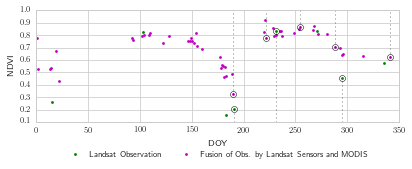

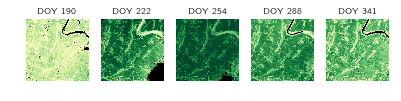

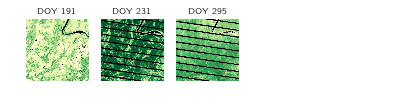

In [28]:
use_plotly = False

ndoy_vis = 4 # number of days to visualize images in EACH growing season
img_subset_size = 300 # unit: pixels
if use_plotly:
    ts_figsize = (12, 3)
else:
    ts_figsize = (6.5, 2)
    
cmap = plt.get_cmap("YlGn")
cmap.set_bad('k')
vmin, vmax = 0.1, 0.85
    
top_vis_doys = dict()
bot_vis_doys = dict()
# top_vis_doys["vis_point"] = [190, 235, 254, 293, 341]
# bot_vis_doys["vis_point"] = [191, 231, 295]
top_vis_doys["vis_point"] = [190, 222, 254, 288, 341]
bot_vis_doys["vis_point"] = [191, 231, 295]

for k in vis_keys:
    tmp_flag = vis_point_ts.loc[k, ('obs')] != no_data
    obs_valid_doy = vis_point_ts.loc[k, ('obs')].index[np.where(tmp_flag)[0]]
    tmp_flag = vis_point_ts.loc[k, ('fuse')] != no_data
    fuse_valid_doy = vis_point_ts.loc[k, ('fuse')].index[np.where(tmp_flag)[0]]
    print "Following Obs. days have fusion values as well: "
    print obs_valid_doy[np.where(np.in1d(obs_valid_doy, fuse_valid_doy))[0]]
    
    fig, ax = plt.subplots(figsize=ts_figsize)
    ax.plot(obs_valid_doy, vis_point_ts.loc[k, [('obs', d) for d in obs_valid_doy]].values, 
            '.g', label="Landsat Observation")
    ax.plot(fuse_valid_doy, vis_point_ts.loc[k, [('fuse', d) for d in fuse_valid_doy]].values, 
            '.m', label="Fusion of Obs. by Landsat Sensors and MODIS")
    plt.setp(ax, xlabel="DOY", ylabel=var_names[select_var_ind].upper())
    ylim=ax.get_ylim()
    
    all_valid_doy = np.union1d(obs_valid_doy, fuse_valid_doy)
    if (k in top_vis_doys.keys()) and (k in bot_vis_doys.keys()):
        npanels = len(top_vis_doys[k]) if len(top_vis_doys[k]) > len(bot_vis_doys[k]) else len(bot_vis_doys[k])
    else:
        npanels = ndoy_vis
    
    # evenly select four days in the first growing season, i.e. before doy 200
    if (k in top_vis_doys.keys()) and (k in bot_vis_doys.keys()):
        vis_doys = top_vis_doys[k]
    else:
        doy_ind = np.where(all_valid_doy <= 200)[0]
        vis_doys = selectVisDoys(all_valid_doy[doy_ind], ndoy_vis, 0, 200)
    vis_doys_keys = [('obs', d) if np.in1d(d, obs_valid_doy) else ('fuse', d) for d in vis_doys]
    if not use_plotly:
        ax.plot(vis_doys, vis_point_ts.loc[k, vis_doys_keys], 'o', markersize=6, 
                markerfacecolor="None", markeredgecolor='k', markeredgewidth=0.5, label='_nolegend_')
    for vdk in vis_doys_keys:
        ax.plot([vdk[1], vdk[1]], [vis_point_ts.loc[k, vdk], ylim[1]], ':k', linewidth=0.5, 
                label="_nolegend_")
    # visualize the image subset
    img_data_dir = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-fusion-ts-new/aqua-and-terra"
    img_fig1, img_ax = plt.subplots(1, npanels, 
                                    figsize=(ts_figsize[0], ts_figsize[0]/npanels))
    top_fig_height = ts_figsize[0]/len(vis_doys_keys)
    
    for ivdk, vdk in enumerate(vis_doys_keys):
        file_prefix = "plndsr_500.126046.2015" if vdk[0]=="fuse" else "sub_lndsr.126046.2015"
        file_suffix = ".bin"
        fname = "{0:s}{1:03d}.{2:s}{3:s}".format(file_prefix, vdk[1], var_names[select_var_ind], file_suffix)
        fname = os.path.join(img_data_dir, fname)
        # read image subset
        vis_img_sub = readRasterSubset(fname, 
                                       vis_point_img.loc[k, 'sample'], vis_point_img.loc[k, 'line'], 
                                       img_subset_size)
        vis_img_sub = vis_img_sub.T
        # filter image and create masked array for plotting
        vis_img_sub[vis_img_sub<0.] = no_data
        vis_img_sub[vis_img_sub>1] = no_data
        vis_img_sub = np.ma.masked_equal(vis_img_sub, no_data)
        # plot the image subset
        img_obj = img_ax[ivdk].imshow(vis_img_sub, cmap=cmap, vmin=vmin, vmax=vmax)
        img_ax[ivdk].grid(visible=False)
        img_ax[ivdk].set_axis_off()
        plt.setp(img_ax[ivdk], title="DOY {0:d}".format(vdk[1]))
        # img_fig.colorbar(img_obj)
    for i in range(ivdk, npanels):
        img_ax[i].set_axis_off()
    
    # evenly select four days in the second growing season, i.e. after doy 200
    if (k in top_vis_doys.keys()) and (k in bot_vis_doys.keys()):
        vis_doys = bot_vis_doys[k]
    else:
        doy_ind = np.where(all_valid_doy > 200)[0]
        vis_doys = selectVisDoys(all_valid_doy[doy_ind], ndoy_vis, 200, 365)
    vis_doys_keys = [('obs', d) if np.in1d(d, obs_valid_doy) else ('fuse', d) for d in vis_doys]
    if not use_plotly:
        ax.plot(vis_doys, vis_point_ts.loc[k, vis_doys_keys], 'o', markersize=6, 
                markerfacecolor="None", markeredgecolor='k', markeredgewidth=0.5, label='_nolegend_')
    for vdk in vis_doys_keys:
        ax.plot([vdk[1], vdk[1]], [ylim[0], vis_point_ts.loc[k, vdk]], ':k', linewidth=0.5, 
                label="_nolegend_")
    # visualize the image subset
    img_data_dir = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-fusion-ts-new/aqua-and-terra"
    img_fig2, img_ax = plt.subplots(1, npanels, 
                                    figsize=(ts_figsize[0], ts_figsize[0]/npanels))

    for ivdk, vdk in enumerate(vis_doys_keys):
        file_prefix = "plndsr_500.126046.2015" if vdk[0]=="fuse" else "sub_lndsr.126046.2015"
        file_suffix = ".bin"
        fname = "{0:s}{1:03d}.{2:s}{3:s}".format(file_prefix, vdk[1], var_names[select_var_ind], file_suffix)
        fname = os.path.join(img_data_dir, fname)
        # read image subset
        vis_img_sub = readRasterSubset(fname, 
                                       vis_point_img.loc[k, 'sample'], vis_point_img.loc[k, 'line'], 
                                       img_subset_size)
        vis_img_sub = vis_img_sub.T
        # filter image and create masked array for plotting
        vis_img_sub[vis_img_sub<0.] = no_data
        vis_img_sub[vis_img_sub>1] = no_data
        vis_img_sub = np.ma.masked_equal(vis_img_sub, no_data)
        # plot the image subset
        img_obj = img_ax[ivdk].imshow(vis_img_sub, cmap=cmap, vmin=vmin, vmax=vmax)
        img_ax[ivdk].grid(visible=False)
        img_ax[ivdk].set_axis_off()
        plt.setp(img_ax[ivdk], title="DOY {0:d}".format(vdk[1]))
        # img_fig.colorbar(img_obj)
    for i in range(ivdk, npanels):
        img_ax[i].set_axis_off()

    if use_plotly:
        plotly_fig = plotly.tools.mpl_to_plotly(fig)
        iplot(plotly_fig)
    else:
        plt.setp(ax, ylim=ylim)
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)
        fig.savefig("../figures/fusion_demo_pixel_x{0:d}_y{1:d}_ts.png".format(vis_point_img.loc[k, 'sample'], vis_point_img.loc[k, 'line']), 
                    dpi=dpi, bbox_inches="tight", pad_inches=0.)
        img_fig1.savefig("../figures/fusion_demo_pixel_x{0:d}_y{1:d}_img_top_panel.png".format(vis_point_img.loc[k, 'sample'], vis_point_img.loc[k, 'line']), 
                         dpi=dpi, bbox_inches="tight", pad_inches=0.)
        img_fig2.savefig("../figures/fusion_demo_pixel_x{0:d}_y{1:d}_img_bot_panel.png".format(vis_point_img.loc[k, 'sample'], vis_point_img.loc[k, 'line']), 
                         dpi=dpi, bbox_inches="tight", pad_inches=0.)

## Compare different types of time series

In [94]:
ts_data_compare_list = [ts_ndvi_fuse_aq_merge]
ts_name_compare_list = ["NDVI A+T"]
ts_marker_compare_list = [".g"]

# start_ind = 0
# select_ind = np.arange(start_ind, start_ind+2, dtype=int)
# select_keys = ts_data_compare_list[0].index[select_ind]

# select_keys = ['068333-p05', 
#                '011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02']
select_keys = np.random.choice(ts_data_compare_list[0].index, 1, replace=False)

    
gt.plotTs([ts_data.columns.values for ts_data in ts_data_compare_list], \
    [ts_data.loc[select_keys, :] for ts_data in ts_data_compare_list], \
    pd.Series(["coords: ({0[0]}, {0[1]})".format(img_points_ctr.loc[k, :]) for k in select_keys], index=select_keys), \
    fig_kw_dict=dict(figsize=(10, 4)), \
    plot_kw_dict_list=[dict(label=tsn, markersize=6) for i, tsn in enumerate(ts_name_compare_list)], \
    ax_kw_dict=dict(xlim=(0, 366), ylim=(0, 1.)), \
    style_list=ts_marker_compare_list, use_plotly=True, save_fig=False)

In [101]:
tmp="{{0:s}}_{{1:0{0:d}d}}_{{2:0{1:d}d}}_{{3:0{2:d}d}}_{{4:0{3:d}d}}".format(4, 4, 3, 2)
tmp.format("fdd", 10, 200, 50, 50)

'fdd_0010_0200_050_50'

In [98]:
test = pd.read_table("/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/test.txt", delim_whitespace=True, 
                     skiprows=3, header=None)
fig, ax = plt.subplots()
ax.plot(test.loc[:, 0], test.loc[:, 1], 'or')
ax.plot(ts_evi_fuse_aq_merge.columns.values, ts_ndvi_fuse_aq_merge.loc[select_keys[0], :].values, 'og')
plt.setp(ax, ylim=(0, 1))
plotly_fig = plotly.tools.mpl_to_plotly(fig)
iplot(plotly_fig)

In [29]:
# # ts_data_compare_list = [ts_ndvi_fuse_aq_merge, ts_evi_fuse_aq_merge, 
# #                         ts_swir1_fuse_aq_merge, ts_swir2_fuse_aq_merge]
# # ts_name_compare_list = ["NDVI A+T", "EVI A+T", "SWIR1 A+T", "SWIR2 A+T"]
# # ts_marker_compare_list = [".b", ".r", "xg", "xc"]
# ts_data_compare_list = [ts_evi_fuse_aq_merge, ts_lswi_merge]
# ts_name_compare_list = ["EVI A+T", "LSWI A+T"]
# ts_marker_compare_list = [".g", ".b"]

# # start_ind = 0
# # select_ind = np.arange(start_ind, start_ind+2, dtype=int)
# # select_keys = ts_data_compare_list[0].index[select_ind]

# select_keys = ['004622-p10', 
#                '011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02']
# # select_keys = np.random.choice(ts_data_compare_list[0].index, 5, replace=False)
    
# gt.plotTs([ts_data.columns.values for ts_data in ts_data_compare_list], \
#     [ts_data.loc[select_keys, :] for ts_data in ts_data_compare_list], \
#     pd.Series(["coords: ({0[0]}, {0[1]})".format(geo_points.loc[k, :]) for k in select_keys], index=select_keys), \
#     fig_kw_dict=dict(figsize=(10, 4)), \
#     plot_kw_dict_list=[dict(label=tsn, markersize=6) for i, tsn in enumerate(ts_name_compare_list)], \
#     ax_kw_dict=dict(xlim=(0, 366), ylim=(0, 1.)), \
#     style_list=ts_marker_compare_list, use_plotly=True, save_fig=False)

In [30]:
# # Number of valid time series values in each type of time series
# ts_data_valid_cnt_list = [np.sum(ts_data!=no_data, axis=1) for ts_data in ts_data_compare_list]

# print ts_name_compare_list[0], ts_data_valid_cnt_list[0].head()
# print ts_name_compare_list[1], ts_data_valid_cnt_list[1].head()

## Select the type of time series data to use in the following analysis!!!

In [27]:
# # ts_data = ts_ndvi_fuse_aq_merge.copy()
# ts_data1 = ts_ndvi_fuse_terra.copy()
# ts_data2 = ts_evi_fuse_aq_merge.copy()
# # ts_data = ts_gcvi_merge.copy()
# # ts_data1 = ts_lswi_merge.copy()
# ts_data = ts_ndvi_fuse_aq_merge.copy()

ts_data_list = []
ts_data_label_list = []

ts_data_list.append(ts_ndvi_fuse_aq_merge.copy())
ts_data_label_list.append("NDVI")

ts_data_list.append(ts_ndvi_fuse_terra.copy())
ts_data_label_list.append("NDVI Terra")

ts_data_list.append(ts_evi_fuse_aq_merge.copy())
ts_data_label_list.append("EVI")

## Our tailored temporal fitting
* fit a quadratic curve to a few points around DOY 250 after visual inspection of a lot of time series. 

In [28]:
def quadFunc(x, a, p1, p2):
    # y = a*(x**2 + p1*x + p2)
    return np.poly1d([a, a*p1, a*p2])(x)

def quadFuncUnc(x, a, p1, p2):
    return a * x**2 + a*p1 * x + a*p2

def quadPeakConstrained(ts_data, row_key, beg_doy, end_doy, no_data=-9999, max_iter=100):
    # Read x and y data from the given time series data
    ts_section = ts_data.loc[row_key, beg_doy:end_doy]
    tmp_ind = np.where(ts_section != no_data)[0]
    y0 = ts_section.values[tmp_ind]
    x0 = ts_section.index.values[tmp_ind]
    x = np.copy(x0)
    y = np.copy(y0)
    
    peak_x = 250
    max_y = np.max(y)
    p1_0 = -2*peak_x
    a_0 = -1
    p2_0 = max_y/a_0 - (-0.5*p1_0)**2 - (-0.5*p1_0)*p1_0
    p0 = np.array([a_0, p1_0, p2_0])
    plbd = [-np.inf, -2*280, -np.inf]
    pubd = [0, -2*220, np.inf]
    for i in range(max_iter):
        max_y = np.max(y)
        try:
            popt, pcov = sp.optimize.curve_fit(quadFunc, x, y, 
                                               p0 = p0, 
                                               bounds=(plbd, pubd))
        except RuntimeError as e:
            if str(e).find("Optimal parameters not found: ") == -1:
                raise e
            else:
                peak_x = 0
                peak_x_std = 0
                peak_y = 0
                peak_y_std = 0
                quad_coef = np.zeros_like(p0)
                quad_coef_std = np.zeros_like(p0)
                quad_func = None
                quad_func_unc = None
                return peak_x, peak_x_std, peak_y, peak_y_std, \
                       quad_coef, quad_coef_std, quad_func, quad_func_unc, max_y

        # Use the uncertainties package to get the uncertainty of each parameter 
        # from the covariance matrix of the parameter estimates
        unc_p = unc.correlated_values(popt, pcov)
        quad_coef = popt
        quad_coef_std = np.array([pv.std_dev for pv in unc_p])
        
        quad_func = lambda x: quadFunc(x, *popt)
        quad_func_unc = lambda x: quadFuncUnc(x, *unc_p)
        
        peak_x = -0.5 * popt[1]
        peak_x_std = (-0.5 * unc_p[1]).std_dev
        
        unc_x = unc.ufloat(peak_x, peak_x_std)
        unc_peak_y = quad_func_unc(unc_x)
        peak_y = unc_peak_y.nominal_value
        peak_y_std = unc_peak_y.std_dev

        unc_yfit = [quad_func_unc(xv) for xv in x]
        yfit_nom, yfit_std = zip(*[(uyv.nominal_value, uyv.std_dev) for uyv in unc_yfit])
        yfit_nom = np.array(yfit_nom)
        yfit_std = np.array(yfit_std)
                
        # see if the difference between fitted y and measured y is larger than the 3*std_dev
        tmp_flag = abs(yfit_nom-y) < 3*yfit_std
#         tmp_flag = abs(yfit_nom-y) < np.inf
#         tmp_flag = (yfit_nom-y) > -3*yfit_std
        if np.sum(np.logical_not(tmp_flag)) == 0:
            break
        x = x[tmp_flag]
        y = y[tmp_flag]
    
    return peak_x, peak_x_std, peak_y, peak_y_std, \
           quad_coef, quad_coef_std, quad_func, quad_func_unc, max_y

In [29]:
# def gaussFunc(x, a, mu, sig):
#     return a*np.exp(-(x-mu)**2/(2.*sig**2))

# def gaussFuncUnc(x, a, mu, sig):
#     return a*umath.exp(-(x-mu)**2/(2.*sig**2))

# def gaussPeakConstrained(ts_data, row_key, beg_doy, end_doy, no_data=-9999, max_iter=100):
#     # Read x and y data from the given time series data
#     ts_section = ts_data.loc[row_key, beg_doy:end_doy]
#     tmp_ind = np.where(ts_section != no_data)[0]
#     y0 = ts_section.values[tmp_ind]
#     x0 = ts_section.index.values[tmp_ind]
#     x = np.copy(x0)
#     y = np.copy(y0)
    
#     peak_x = 250
#     max_y = np.max(y)
#     a_0 = 1
#     mu_0 = peak_x
#     sig_0 = 15
#     sigma = np.ones_like(y)
#     for i in range(max_iter):       
#         max_y = np.max(y)
#         try:
#             popt, pcov = sp.optimize.curve_fit(gaussFunc, x, y, 
#                                                p0 = [a_0, mu_0, sig_0], 
#                                                bounds=([0, 220, 0], [1, 280, 25]))
#         except RuntimeError as e:
#             if str(e).find("Optimal parameters not found: ") == -1:
#                 raise e
#             else:
#                 peak_x = 0
#                 peak_y = 0
#                 peak_y_std = 0
#                 gauss_coef = 0
#                 gauss_func = None
#                 return peak_x, peak_y, peak_y_std, gauss_sig, gauss_func, max_y

#         # Use the uncertainties package to get the uncertainty of each parameter 
#         # from the covariance matrix of the parameter estimates
#         unc_p = unc.correlated_values(popt, pcov)
        
#         gauss_sig = popt[2]
#         gauss_func = lambda x: gaussFunc(x, *popt)
#         peak_x = popt[1]
# #         unc_peak_y = unc_p[0]*np.exp(-(peak_x-unc_p[1])**2/(2.*unc_p[2]**2))
#         unc_peak_y = gaussFuncUnc(peak_x, *unc_p)
#         peak_y = unc_peak_y.nominal_value
#         peak_y_std = unc_peak_y.std_dev
                
# #         unc_yfit = unc_p[0]*np.exp(-(x-unc_p[1])**2/(2.*unc_p[2]**2))
#         unc_yfit = [gaussFuncUnc(xv, *unc_p) for xv in x]
#         yfit_nom, yfit_std = zip(*[(uyv.nominal_value, uyv.std_dev) for uyv in unc_yfit])
#         yfit_nom = np.array(yfit_nom)
#         yfit_std = np.array(yfit_std)
                        
# #         if peak_y + 3*peak_y_std < max_y:
# #             a_0 = popt[0]
# #             p1_0 = popt[1]
# #             p2_0 = popt[2]
            
# #             # see if the difference between fitted y and measured y is larger than the 3*std_dev
# #             tmp_flag = y0 - (peak_y + 3*peak_y_std) < 0
# # #             tmp_flag = abs(yfit_nom-y) < 3*yfit_std
# # #             tmp_flag = abs(yfit_nom-y) < np.inf
# # #             tmp_flag = (yfit_nom-y) > -3*yfit_std
# #             x = x0[tmp_flag]
# #             y = y0[tmp_flag]

# #             sigma = 1./y0fit_std[tmp_flag]
# # #             sigma = np.ones_like(y)
# #         else:
# #             break        
        
#         # see if the difference between fitted y and measured y is larger than the 3*std_dev
#         tmp_flag = abs(yfit_nom-y) < 3*yfit_std
# #         tmp_flag = abs(yfit_nom-y) < np.inf
# #         tmp_flag = (yfit_nom-y) > -3*yfit_std
#         if np.sum(np.logical_not(tmp_flag)) == 0:
#             break
#         x = x[tmp_flag]
#         y = y[tmp_flag]
    
#     return peak_x, peak_y, peak_y_std, gauss_sig, gauss_func, max_y

In [30]:
# def dblogFunc(x, p1, p2, p3, p4):
#     return 1./(1+np.exp((p1-x)/p2)) - 1./(1+np.exp((p3-x)/p4))

# def dblogFuncUnc(x, p1, p2, p3, p4):
#     return 1./(1+umath.exp((p1-x)/p2)) - 1./(1+umath.exp((p3-x)/p4))

# def dblogPeakConstrained(ts_data, row_key, beg_doy, end_doy, no_data=-9999, max_iter=100):
#     # Read x and y data from the given time series data
#     ts_section = ts_data.loc[row_key, beg_doy:end_doy]
#     tmp_ind = np.where(ts_section != no_data)[0]
#     y0 = ts_section.values[tmp_ind]
#     x0 = ts_section.index.values[tmp_ind]
#     x = np.copy(x0)
#     y = np.copy(y0)
    
#     peak_x = 250
#     max_y = np.max(y)
#     p1_0 = 225.
#     p2_0 = 5.
#     p3_0 = 275.
#     p4_0 = 10.
#     p0 = np.array([p1_0, p2_0, p3_0, p4_0])
#     sigma = np.ones_like(y)
#     for i in range(max_iter):       
#         max_y = np.max(y)
#         try:
#             popt, pcov = sp.optimize.curve_fit(dblogFunc, x, y,
#                                                p0 = p0, 
#                                                bounds=([200., 0., 200., 0.], [300., np.inf, 300., np.inf]))
#         except RuntimeError as e:
#             if str(e).find("Optimal parameters not found: ") == -1:
#                 raise e
#             else:
#                 peak_x = 0
#                 peak_y = 0
#                 peak_y_std = 0
#                 model_coef = np.zeros_like(p0)
#                 model_func = None
#                 return peak_x, peak_y, peak_y_std, model_coef, model_func, max_y

#         model_coef = popt
#         model_func = lambda x: dblogFunc(x, *popt)            
#         tmp_x = np.arange(np.min(x), np.max(x), 1e-3)
#         tmp_y = model_func(tmp_x)
#         peak_x = tmp_x[np.argmax(tmp_y)]     

#         # Use the uncertainties package to get the uncertainty of each parameter 
#         # from the covariance matrix of the parameter estimates
#         unc_p = unc.correlated_values(popt, pcov)
        
#         unc_peak_y = dblogFuncUnc(peak_x, *unc_p)
#         peak_y = unc_peak_y.nominal_value
#         peak_y_std = unc_peak_y.std_dev
                
#         unc_yfit = [dblogFuncUnc(xv, *unc_p) for xv in x]
#         yfit_nom, yfit_std = zip(*[(uyv.nominal_value, uyv.std_dev) for uyv in unc_yfit])
#         yfit_nom = np.array(yfit_nom)
#         yfit_std = np.array(yfit_std)
                        
# #         if peak_y + 3*peak_y_std < max_y:
# #             a_0 = popt[0]
# #             p1_0 = popt[1]
# #             p2_0 = popt[2]
            
# #             # see if the difference between fitted y and measured y is larger than the 3*std_dev
# #             tmp_flag = y0 - (peak_y + 3*peak_y_std) < 0
# # #             tmp_flag = abs(yfit_nom-y) < 3*yfit_std
# # #             tmp_flag = abs(yfit_nom-y) < np.inf
# # #             tmp_flag = (yfit_nom-y) > -3*yfit_std
# #             x = x0[tmp_flag]
# #             y = y0[tmp_flag]

# #             sigma = 1./y0fit_std[tmp_flag]
# # #             sigma = np.ones_like(y)
# #         else:
# #             break        
        
#         # see if the difference between fitted y and measured y is larger than the 3*std_dev
#         tmp_flag = abs(yfit_nom-y) < 3*yfit_std
# #         tmp_flag = abs(yfit_nom-y) < np.inf
# #         tmp_flag = (yfit_nom-y) > -3*yfit_std
#         if np.sum(np.logical_not(tmp_flag)) == 0:
#             break
#         x = x[tmp_flag]
#         y = y[tmp_flag]
    
#     return peak_x, peak_y, peak_y_std, model_coef, model_func, max_y

In [92]:
tuple(3*[np.nan])

(nan, nan, nan)

## IMPORTANT Settings for Our Tailored Temporal Fitting

In [31]:
beg_doy = 200
end_doy = 300 # 300

## Test our tailored temporal fitting

In [32]:
# Subplots used in our final regression
final_keys = \
np.array(['004622-p10', '011504-p01', '011504-p05', '012748-p01',
       '012748-p02', '012748-p04', '015361-p10', '015625-p02',
       '015625-p14', '016659-p04', '016668-p03', '016668-p15',
       '017127-p02', '017745-p01', '017850-p04', '017850-p13',
       '018042-p07', '018151-p02', '018151-p12', '018392-p04',
       '018619-p01', '018619-p02', '018619-p05', '020258-p03',
       '020258-p12', '020292-p03', '020861-p10', '022965-p08',
       '022965-p17', '022965-p22', '024019-p02', '024047-p03',
       '024047-p10', '024047-p12', '024751-p02', '024751-p18',
       '024847-p01', '024847-p07', '024847-p24', '025021-p19',
       '025236-p03', '026004-p07', '027202-p22', '027474-p02',
       '027474-p04', '031019-p10', '031019-p17', '032266-p12',
       '032266-p28', '038505-p01', '038505-p07', '038505-p18',
       '038849-p04', '038849-p11', '038849-p26', '038849-p36',
       '039190-p05', '039753-p06', '042489-p23', '043388-p03',
       '043402-p09', '043402-p20', '043716-p03', '047567-p17',
       '050656-p04', '052699-p05', '052699-p15', '055628-p05',
       '060116-p10', '065186-p10', '065186-p18'], dtype=object)

lon    106.472616
lat     20.468841
Name: 043402-p09, dtype: float64
sample    1423
line      1043
Name: 043402-p09, dtype: int64
(241.67465232638941, 1.1137369983708065, 0.8847490199400196, 0.004138889421972435, array([ -1.16108341e-04,  -4.83349305e+02,   5.07866078e+04]), array([  6.38098674e-06,   2.22747400e+00,   9.11916392e+02]), <function <lambda> at 0x2b454f13d6e0>, <function <lambda> at 0x2b454f13d578>, 0.88712304830599997)
lon    106.155207
lat     20.634950
Name: 015625-p02, dtype: float64
sample    315
line      439
Name: 015625-p02, dtype: int64
(243.58701147627846, 2.392275054087686, 0.8361527377473283, 0.0183330480294573, array([ -1.68625374e-04,  -4.87174023e+02,   5.43759909e+04]), array([  2.35297015e-05,   4.78455011e+00,   1.73725460e+03]), <function <lambda> at 0x2b4583329758>, <function <lambda> at 0x2b458328e758>, 0.84744268655800004)


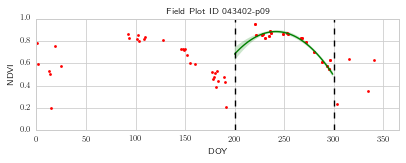

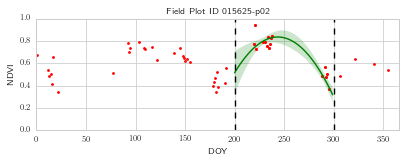

In [33]:
# which TS data you wanna test?
ts_data_idx = 0

ts_data = ts_data_list[ts_data_idx]
# get the keys to subplots to test
# select_keys = np.random.choice(final_keys, size=1, replace=False)

##########################################################
# for our demonstation of NDVI in paper
# select_keys = ['027202-p22','032266-p28','031019-p17','043402-p09','024047-p03','015625-p02','047567-p17']
select_keys = ['043402-p09','015625-p02']
##########################################################

# ##########################################################
# # for our demonstation of EVI in paper
# select_keys = ['038849-p26', '015625-p14', '020258-p12']##
# ##########################################################
# select_keys = ['068333-p05', 
#                '011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02']
select_ind = np.where(np.in1d(ts_data.index, select_keys))[0]

use_plotly=False
ylabel=ts_data_label_list[ts_data_idx]
if use_plotly:
    figsize = (10, 3)
else:
    figsize = (6.5, 2)
for i, k in zip(select_ind, select_keys):
    fit_output = quadPeakConstrained(ts_data, k, beg_doy, end_doy)
#     fit_output = gaussPeakConstrained(ts_data, k, beg_doy, end_doy)
#     fit_output = dblogPeakConstrained(ts_data, k, beg_doy, end_doy)
    print geo_points_ctr.loc[k]
    print img_points_ctr.loc[k]
    print fit_output

    if use_plotly:
        fig, ax = plt.subplots(figsize=figsize)
        
        y = ts_data.loc[k, :].copy()
        x = y.index.values
        y = y.values
        tmp_ind = np.where(y != no_data)[0]
        x = x[tmp_ind]
        y = y[tmp_ind]
        ax.plot(x, y, '.r')

        ts_section = ts_data.loc[k, beg_doy:end_doy].copy()
        tmp_ind = np.where(ts_section != no_data)[0]
        y = ts_section.values[tmp_ind]
        x = ts_section.index.values[tmp_ind]
        xfit = np.arange(beg_doy, end_doy)
        ax.plot(xfit, fit_output[6](xfit), '-g', label="constrained")
        ax.plot([beg_doy, end_doy], [fit_output[8], fit_output[8]], '-k')
        yfit, yfit_std = zip(*[(uncv.nominal_value, uncv.std_dev)for uncv in [fit_output[7](xv) for xv in xfit]])
        yfit = np.array(yfit)
        yfit_std = np.array(yfit_std)*3
        ax.plot(xfit, yfit-yfit_std, '--g')
        ax.plot(xfit, yfit+yfit_std, '--g')

        plt.setp(ax, title=k, xlabel='DOY', ylabel=ylabel, 
                 xlim=(0, 366)) 
        
        plotly_fig = plotly.tools.mpl_to_plotly(fig)
        plotly_fig["data"][4]["fill"] = "tonexty"
        iplot(plotly_fig)
    else:
#         fig = plt.figure(figsize=(9, 2.5))
#         ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
#         ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
        fig, ax = plt.subplots(figsize=figsize)
        ax1 = ax
        ax2 = ax

        y = ts_data.loc[k, :].copy()
        x = y.index.values
        y = y.values
        tmp_ind = np.where(y != no_data)[0]
        x = x[tmp_ind]
        y = y[tmp_ind]
        ax1.plot(x, y, '.r')
        plt.setp(ax1, title=k, xlabel='DOY', ylabel=ylabel, 
                 xlim=(0, 366)) 

        ts_section = ts_data.loc[k, beg_doy:end_doy].copy()
        tmp_ind = np.where(ts_section != no_data)[0]
        y = ts_section.values[tmp_ind]
        x = ts_section.index.values[tmp_ind]
        ax2.plot(x, y, '.r')
        xfit = np.arange(beg_doy, end_doy)
        ax2.plot(xfit, fit_output[6](xfit), '-g', label="constrained")
#         ax2.plot([beg_doy, end_doy], [fit_output[8], fit_output[8]], '-k')
        yfit, yfit_std = zip(*[(uncv.nominal_value, uncv.std_dev)for uncv in [fit_output[7](xv) for xv in xfit]])
        yfit = np.array(yfit)
        yfit_std = np.array(yfit_std)*3
        ax2.fill_between(xfit, yfit-yfit_std, yfit+yfit_std, 
                         facecolor='green', alpha=0.2, edgecolor="None")
        
        plt.setp(ax2, title="Field Plot ID {0:s}".format(k), xlabel='DOY')
        
        ylim = ax1.get_ylim()
        ylim = (0, ylim[1])
        ylim = (0, 1)
        ax1.plot([beg_doy, beg_doy], ylim, '--k')
        ax1.plot([end_doy, end_doy], ylim, '--k')
        plt.setp(ax1, ylim=ylim)
        
        # save figures
        plt.savefig("../figures/ts_quad_fitting_{0:s}_{1:s}".format(ylabel.replace(" ", "_").lower(), k.lower()), 
                    dpi=dpi, bbox_inches="tight", pad_inches=0.)

## Apply our tailored temporal fitting to find peak values of time series

### Tailored temporal fitting for all of given time series

In [34]:
peak_x_cst_list = []
peak_x_std_cst_list = []
peak_y_cst_list = []
peak_y_std_cst_list = []
quad_coef_cst_list = []
max_y_cst_list = []
quad_func_cst_list = []

for ts_idx, ts_data in enumerate(ts_data_list):
    ts_fit = zip(*[quadPeakConstrained(ts_data, rowk, beg_doy, end_doy) for rowk in ts_data.index])

    peak_x_cst = pd.Series(np.array(ts_fit[0]), index=ts_data.index)
    peak_x_std_cst = pd.Series(np.array(ts_fit[1]), index=ts_data.index)
    peak_y_cst = pd.Series(np.array(ts_fit[2]), index=ts_data.index)
    peak_y_std_cst = pd.Series(np.array(ts_fit[3]), index=ts_data.index)
    quad_coef_cst = pd.Series(ts_fit[4], index=ts_data.index)
    max_y_cst = pd.Series(np.array(ts_fit[8]), index=ts_data.index)
    quad_func_cst = {k:func for k, func in zip(ts_data.index, ts_fit[6])}

    print "# of failed fitting", np.sum(peak_y_cst<=0)
    print "# of peak < max", np.sum(peak_y_cst<max_y_cst)
    print "# of peak+3*std < max", np.sum(peak_y_cst+peak_y_std_cst*3<max_y_cst)

    tmp = np.sum(reduce(np.logical_and, [peak_x_cst.loc[ts_data.index]>beg_doy, 
                                         peak_x_cst.loc[ts_data.index]<end_doy, 
                                         peak_y_cst.loc[ts_data.index] > 0]))
    print "# of successful fitting = ", tmp
        
    peak_x_cst_list.append(peak_x_cst)
    peak_x_std_cst_list.append(peak_x_std_cst)
    peak_y_cst_list.append(peak_y_cst)
    peak_y_std_cst_list.append(peak_y_std_cst)
    quad_coef_cst_list.append(quad_coef_cst)
    max_y_cst_list.append(max_y_cst)
    quad_func_cst_list.append(quad_func_cst)

    # plot the distribution of some fitting output for inspection
    pysdata_list = [peak_y_std_cst, 
                    peak_x_std_cst, 
                    np.array([quad_coef_cst.loc[k][0] for k in quad_coef_cst.index])]

    fig, ax_list = plt.subplots(int(np.ceil(len(pysdata_list)/3)), 3, 
                                figsize=(9, np.ceil(len(pysdata_list)/3)*3))
    
    for i, (pysdata, ax) in enumerate(itertools.izip(pysdata_list, ax_list.flat)):
        print
        # plot the distribution of the given data
        binsize = (np.max(pysdata)-np.min(pysdata))/500.
        bins = np.arange(np.min(pysdata), np.max(pysdata), binsize)

        ax.hist(pysdata, bins=bins, normed=True)
        print np.std(pysdata), np.mean(pysdata)+3*np.std(pysdata), \
              np.sum(pysdata>np.mean(pysdata)+3*np.std(pysdata))

        # KDE to estimate the PDF
        kde = sp.stats.gaussian_kde(pysdata)
        pysfit = bins
        pyspdffit = kde(pysfit)
        ax.plot(pysfit, pyspdffit, '-r')

        # get the right side where CDF reaches 0.975 
        pyscdffit = np.array([kde.integrate_box_1d(-np.inf, pv) for pv in pysfit])
        tmp_ind = np.where(pyscdffit>=0.975)[0]
        if len(tmp_ind)>0:
            tmp_ind = tmp_ind[0]
            print tmp_ind-1, pysfit[tmp_ind-1], pyscdffit[tmp_ind-1], pyscdffit[tmp_ind], \
                  np.interp(0.975, pyscdffit[tmp_ind-1:tmp_ind+1], pysfit[tmp_ind-1:tmp_ind+1])
        
    plotly_fig = plotly.tools.mpl_to_plotly(fig)
    iplot(plotly_fig)

# of failed fitting 0
# of peak < max 133
# of peak+3*std < max 2
# of successful fitting =  255

0.00929048001742 0.0401555364763 7
440 0.0406131196357 0.974866420943 0.97532253042 0.0406389388922

9.76891496321 34.4349344554 8
309 38.554604757 0.974909418747 0.975149598555 38.601467791

4.83659969556e-05 2.537249005e-05 0
494 -2.41993640184e-05 0.974960851456 0.975783004917 -2.41762369778e-05


# of failed fitting 0
# of peak < max 139
# of peak+3*std < max 2
# of successful fitting =  255

0.00701790299293 0.0310474112359 8
312 0.0311937470748 0.974955619234 0.975335978885 0.0312050865825

6.81792563732 23.6902101623 7
249 24.7993457513 0.974875068646 0.975122954306 24.849398878

5.18416148796e-05 2.65371895888e-05 0
471 -2.94339372876e-05 0.974374228812 0.975063052253 -2.88095711774e-05


# of failed fitting 0
# of peak < max 161
# of peak+3*std < max 2
# of successful fitting =  255

0.0097269786449 0.0431101122799 5
427 0.0422000569 0.974891598319 0.975201784594 0.0422336324583

6.50615206332 23.3699643316 6
189 22.9000223449 0.974663019324 0.975173613226 22.9793872402

5.42320748128e-05 1.94221177471e-05 0
466 -3.3536465272e-05 0.974158260723 0.975091415081 -3.28886463437e-05


## Plot crop yield against peak NDVI from quadratic fit

In [35]:
def expFunc(x, a, b, c):
    # y = a*exp(b*x) + c
    return a * np.exp(b*x) + c

def linFunc(x, a, b):
    # y = a * x + b
    return a * x + b

def mlinFunc(x, *args):
    # y[i] = p[0]*x[0, i] + p[1]*x[1, i] + ... + p[k]*x[k, i] + p[k+1]
    # x: k x M array
    # p: k+1 vector
    # return, 
    # y: M vector
    
    # pad x with 1 for the constant term in p
    p = []
    for arg in args:
        p.append(arg)
    p = np.array(p)
    return np.dot(p, np.append(x, np.ones((1, x.shape[1])), axis=0))

def fitLinODR(x, y, x_std=None, y_std=None):
    model4odr = spodr.polynomial(1)
    model4odr_func = lambda beta, x: beta[0] + beta[1] * x
    data4odr = spodr.Data(x, y, 
                          we=None if x_std is None else x_std**2, 
                          wd=None if y_std is None else y_std**2)
    odrfit = spodr.ODR(data4odr, model4odr, maxit=10000)
    odrfit_out = odrfit.run()
    pearsonr = sp.stats.pearsonr(x, y)
    r2 = pearsonr[0]**2
    xfit = np.array([np.min(x), np.max(x)])
    yfit = model4odr_func(odrfit_out.beta, xfit)
    return odrfit_out.beta, (r2, r2), xfit, yfit, lambda x: model_func(odrfit_out.beta, x), lambda x: model_func(odrfit_out.beta, x)

def fitLinOLS(x, y, x_std=None, y_std=None):
    model_func = linFunc
    try:
        coef, pcov = sp.optimize.curve_fit(model_func, x, y, method="trf", max_nfev=1000, 
                                           sigma=y_std)
        r2 = 1 - np.sum((y - model_func(x, *coef))**2)/np.sum((y - np.mean(y))**2)
        # adjusted r2
        adj_r2 = 1 - (1-r2) * (float(x.size)-1.) / (float(x.size)-1-1)
        xfit = np.array([np.min(x), np.max(x)])
        yfit = model_func(xfit, *coef)
        # get function to calculate uncertainty
        unc_coef = unc.correlated_values(coef, pcov)
        coef_nom, coef_std = zip(*[(ucv.nominal_value, ucv.std_dev) for ucv in unc_coef])
        unc_coef = unumpy.uarray(coef_nom, coef_std)
        def model_func_unc(x):
            x = np.array([x, np.ones_like(x)])
            tmpy, tmpy_std = zip(*[(pv.nominal_value, pv.std_dev) for pv in 
                                   [np.sum(x[:, i]*unc_coef) for i in range(x.shape[1])]])
            return np.array(tmpy_std)
    except RuntimeError as e:
        if str(e).find("Optimal parameters not found: ") == -1:
            raise e
        else:
            print "Optimal parameters not found", str(model_func)
            coef = None
            r2 = None
            adj_r2 = None
            xfit = None
            yfit = None
    return coef, (r2, adj_r2), xfit, yfit, lambda x: model_func(x, *coef), model_func_unc

def fitExpOLS(x, y, x_std=None, y_std=None):
    model_func = expFunc
    try:
        coef, pcov = sp.optimize.curve_fit(model_func, x, y, method="trf", max_nfev=1000)
        r2 = 1 - np.sum((y - model_func(x, *coef))**2)/np.sum((y - np.mean(y))**2)
        # adjusted r2
        adj_r2 = 1 - (1-r2) * (float(x.size)-1.) / (float(x.size)-1-1)
        xfit = np.array([np.min(x), np.max(x)])
        yfit = model_func(xfit, *coef)
        # get function to calculate uncertainty
        unc_coef = unc.correlated_values(coef, pcov)
        tmp_func = unc.wrap(model_func)
#         model_func_unc = lambda x: tmp_func(x, *unc_coef)
        def model_func_unc(x):
            tmpy, tmpy_std = zip(*[(pv.nominal_value, pv.std_dev) for pv in [tmp_func(xv, *unc_coef) for xv in x]])
            return np.array(tmpy_std)
    except RuntimeError as e:
        if str(e).find("Optimal parameters not found: ") == -1:
            raise e
        else:
            print "Optimal parameters not found", str(model_func)
            coef = None
            r2 = None
            adj_r2 = None
            xfit = None
            yfit = None
    return coef, (r2, adj_r2), xfit, yfit, lambda x: model_func(x, *coef), model_func_unc

def fitMLinOLS(x, y, x_std=None, y_std=None):
    # x, x_std: k x M array
    # y, y_std: M vector
    ndim = x.shape[0]
    if ndim == 1:
        model_func = lambda x, p1, p2: mlinFunc(x, p1, p2)
    elif ndim == 2:
        model_func = lambda x, p1, p2, p3: mlinFunc(x, p1, p2, p3)
    elif ndim == 3:
        model_func = lambda x, p1, p2, p3, p4: mlinFunc(x, p1, p2, p3, p4)
    elif ndim == 4:
        model_func = lambda x, p1, p2, p3, p4, p5: mlinFunc(x, p1, p2, p3, p4, p5)
    else:
        raise RuntimeError("Number of variates not implemented yet!")
    
    try:
        coef, pcov = sp.optimize.curve_fit(model_func, x, y, method="trf", max_nfev=1000)
        r2 = 1 - np.sum((y - model_func(x, *coef))**2)/np.sum((y - np.mean(y))**2)
        # adjusted r2
        adj_r2 = 1 - (1-r2) * (float(x.size/ndim)-1.) / (float(x.size/ndim)-ndim-1)
        xfit_ncols = 2**ndim
        xfit = np.zeros((ndim, xfit_ncols))
        tmp = np.array([np.min(x, axis=1), np.max(x, axis=1)])
        xfit = np.array(np.meshgrid(*(tmp.T))).reshape(ndim, -1)
        yfit = model_func(xfit, *coef)
        # get function to calculate uncertainty
        unc_coef = unc.correlated_values(coef, pcov)
        tmp_func = unc.wrap(model_func)
#         model_func_unc = lambda x: tmp_func(x, *unc_coef)
        def model_func_unc(tmpx):
            tmpy, tmpy_std = zip(*[(pv.nominal_value, pv.std_dev) for pv in [tmp_func(xv, *unc_coef) for xv in tmpx]])
            return np.array(tmpy_std)
    except RuntimeError as e:
        if str(e).find("Optimal parameters not found: ") == -1:
            raise e
        else:
            print "Optimal parameters not found", str(model_func)
            coef = None
            r2 = None
            adj_r2 = None
            xfit = None
            yfit = None
    return coef, (r2, adj_r2), xfit, yfit, lambda x: model_func(x, *coef), model_func_unc

In [36]:
def statsLinOLS(x, y, x_std=None, y_std=None):
    # x, x_std: k x M array, k variables and M observations
    # y, y_std: M vector, M response observations
    xfit = x.copy()
    x = x.T # transpose to M x k for statsmodels library
    x = sm.add_constant(x)
    
    # for statsmodels linear regression
    # y = p0 + p1 * x1 + p2 * x2 + ... + pk * xk
    model = sm.OLS(y, x)
    results = model.fit()
    coef = results.params
    r2 = results.rsquared
    adj_r2 = results.rsquared_adj
    aic = results.aic
    yfit = results.fittedvalues
    
#     ndim = x.shape[1]-1
#     xfit_ncols = 2**ndim
#     xfit = np.zeros((ndim, xfit_ncols))
#     tmp = np.array([np.min(x[:, 1:], axis=0), np.max(x[:, 1:], axis=0)])
#     xfit = np.array(np.meshgrid(*(tmp.T))).reshape(ndim, -1)
    
    # return a model function to predict for k vars x M obs input
    model_func = lambda x: results.predict(sm.add_constant(x.T))
    
    coef_std = results.bse
    unc_coef = unumpy.uarray(results.params, coef_std)
#     def model_func_unc(tmpx):
#         x = sm.add_constant(tmpx.T)
#         tmpy, tmpy_std = zip(*[(pv.nominal_value, pv.std_dev) for pv in 
#                                [np.sum(x[i, :]*unc_coef) for i in range(len(x))]])
#         return np.array(tmpy_std)

    model_func_unc = lambda x: wls_prediction_std(results, sm.add_constant(x.T), weights=np.ones(x.T.shape[0]))[0]
    return results, (r2, adj_r2, aic), xfit, yfit, model_func, model_func_unc

In [37]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
rstats = importr('stats')
rbase = importr('base')

In [63]:
def rLinOLS(x, y, x_std=None, y_std=None):
    # x, x_std: k x M array, k variables and M observations
    # y, y_std: M vector, M response observations
    xfit = x.copy()
    
    x = x.T # transpose to M x k for statsmodels library
    nobs = x.shape[0]
    x = x.reshape((nobs, -1))
    nxvar = x.shape[1]
    # set up a pandas dataframe
    xvar_names = ["x{0:d}".format(i) for i in range(nxvar)]
    df = pd.DataFrame(x, columns=xvar_names)
    df['y'] = y
    rdf = pandas2ri.py2ri(df)
    rlm = rstats.lm("y ~ {0:s}".format(" + ".join(xvar_names)), data=rdf)
    rlm_sum = rbase.summary(rlm)
    
    results = rlm_sum.rx('coefficients')
    r2 = rlm_sum.rx('r.squared')[0][0]
    adj_r2 = rlm_sum.rx('adj.r.squared')[0][0]
    aic = rstats.AIC(rlm)[0]
    
    def model_func(x):
        x = x.T.reshape((x.T.shape[0], -1))
        df = pd.DataFrame(x, columns=["x{0:d}".format(i) for i in range(x.shape[1])])
        return np.array(rstats.predict(rlm, df))
    def model_func_ci(x):
        x = x.T.reshape((x.T.shape[0], -1))
        df = pd.DataFrame(x, columns=["x{0:d}".format(i) for i in range(x.shape[1])])
        return np.array(rstats.predict(rlm, df, interval="confidence"))
    def model_func_pi(x):
        x = x.T.reshape((x.T.shape[0], -1))
        df = pd.DataFrame(x, columns=["x{0:d}".format(i) for i in range(x.shape[1])])
        return np.array(rstats.predict(rlm, df, interval="prediction"))
    
    yfit = model_func(xfit)
    
    return results, (r2, adj_r2, aic), xfit, yfit, model_func, (model_func_ci, model_func_pi)

## Constrained quad fitting, 1x1 crop, multivariate linear regression

Number of valid subplots from our filtering = 70
Number of Crop Type =  17
For Multivariate combination Peak of NDVI + ALOS HH 259 + ALOS HV 259
Number of data points to compare:
[0, 0]
Model parameters:  $coefficients
               Estimate Std. Error    t value     Pr(>|t|)
(Intercept) -7.57484831 1.94435753 -3.8958104 2.311236e-04
x0          14.07889099 2.20064657  6.3976157 1.879409e-08
x1           0.02076635 0.03613445  0.5746966 5.674504e-01
x2          -0.05366799 0.05387308 -0.9961931 3.227947e-01

 <function rLinOLS at 0x2b4587ba0410>
R-square = 0.411, Adjusted R2 = 0.384, AIC = 184.817
Correlation Coef. Squared between Prediction and Field:  0.410745504051
For Multivariate combination Peak of NDVI + ALOS HV 259
Number of data points to compare:
[0, 0]
Model parameters:  $coefficients
               Estimate Std. Error    t value     Pr(>|t|)
(Intercept) -7.57060452 1.93460140 -3.9132632 2.155097e-04
x0          14.32628543 2.14731869  6.6717090 5.833878e-09
x1          -0.

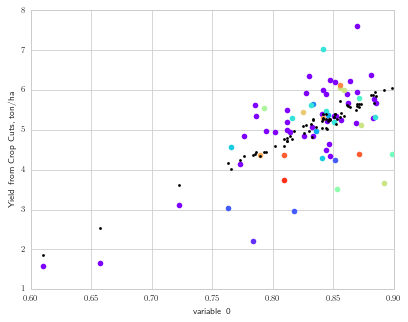

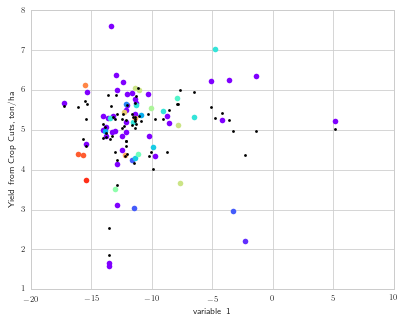

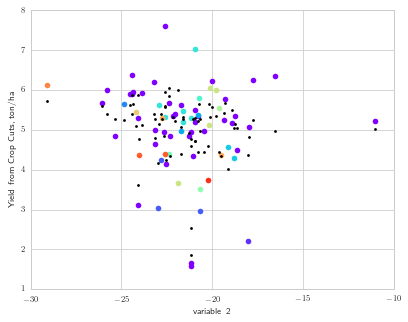

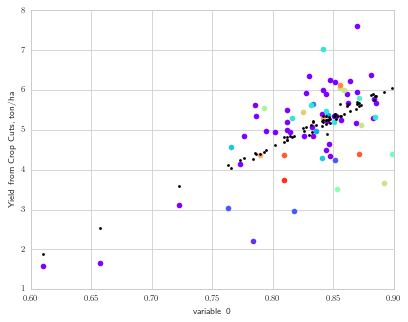

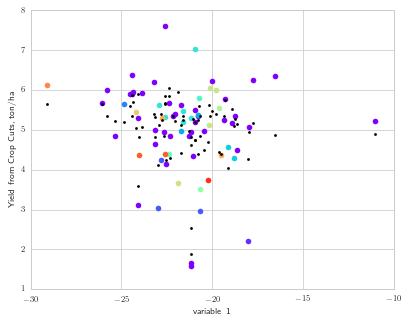

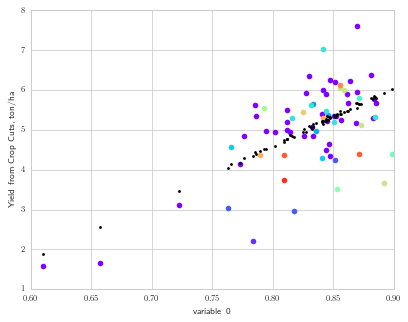

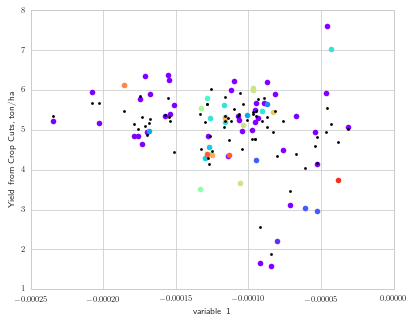

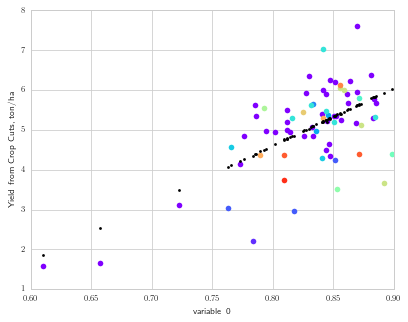

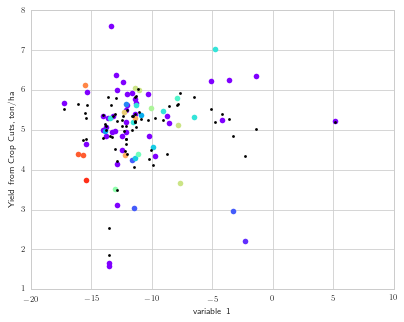

In [79]:
use_plotly = False
figsize = (6.5, 5)
# Constrained quad fitting, 1x1 crop, multivariate linear regression

# fitting approach
# fit_func = fitMLinOLS
fit_func = rLinOLS

select_ts_idx = [0]

cond_list = [single_crop_pix_flag.loc[ts_data.index],
             single_pix_subp_flag.loc[ts_data.index], 
             pix_frac_flag.loc[ts_data.index], 
             np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.logical_not(np.in1d(ts_data.index, ['011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
             np.ones(len(ts_data.index), dtype=np.bool)]
for ts_idx in select_ts_idx:
    tmp_keys = ts_data_list[select_ts_idx[0]].index
    cond_list.append(peak_x_cst_list[ts_idx].loc[tmp_keys]>beg_doy)
    cond_list.append(peak_x_cst_list[ts_idx].loc[tmp_keys]<end_doy)
    cond_list.append(peak_y_cst_list[ts_idx].loc[tmp_keys]>0)
    cond_list.append(peak_y_cst_list[ts_idx].loc[tmp_keys]
                     +3*peak_y_std_cst_list[ts_idx].loc[tmp_keys]>max_y_cst_list[ts_idx].loc[tmp_keys])
    
valid_flag = reduce(np.logical_and, cond_list)
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print "Number of valid subplots from our filtering = {0:d}".format(len(valid_keys))

# select some data points not included in our regression to visually inspect 
# their potential impact on our regression. 
compare_keys_list = []
cond_list = [single_crop_pix_flag.loc[ts_data.index],
             single_pix_subp_flag.loc[ts_data.index], 
             pix_frac_flag.loc[ts_data.index], 
             np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.logical_not(np.in1d(ts_data.index, ['011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
             np.ones(len(ts_data.index), dtype=np.bool)]
for ts_idx in select_ts_idx:
    tmp_keys = ts_data_list[select_ts_idx[0]].index
    cond_list.append(peak_x_cst_list[ts_idx].loc[tmp_keys]>beg_doy)
    cond_list.append(peak_x_cst_list[ts_idx].loc[tmp_keys]<end_doy)
    cond_list.append(peak_y_cst_list[ts_idx].loc[tmp_keys]>0)
    cond_list.append(peak_y_cst_list[ts_idx].loc[tmp_keys]
                     +3*peak_y_std_cst_list[ts_idx].loc[tmp_keys]>max_y_cst_list[ts_idx].loc[tmp_keys])
cp_flag = reduce(np.logical_and, cond_list)
compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

cond_list = [single_crop_pix_flag.loc[ts_data.index],
             single_pix_subp_flag.loc[ts_data.index], 
             pix_frac_flag.loc[ts_data.index], 
             np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.logical_not(np.in1d(ts_data.index, ['011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
             np.ones(len(ts_data.index), dtype=np.bool)]
for ts_idx in select_ts_idx:
    tmp_keys = ts_data_list[select_ts_idx[0]].index
    cond_list.append(peak_x_cst_list[ts_idx].loc[tmp_keys]>beg_doy)
    cond_list.append(peak_x_cst_list[ts_idx].loc[tmp_keys]<end_doy)
    cond_list.append(peak_y_cst_list[ts_idx].loc[tmp_keys]>0)
    cond_list.append(peak_y_cst_list[ts_idx].loc[tmp_keys]
                     +3*peak_y_std_cst_list[ts_idx].loc[tmp_keys]>max_y_cst_list[ts_idx].loc[tmp_keys])
cp_flag = reduce(np.logical_and, cond_list)
compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

# Multiple combination of multivariate to test
multivar_dict = dict()
# first combo of multivar
tmp_label = ", ".join([ts_data_label_list[ts_idx] for ts_idx in select_ts_idx])
tmp_label = "Peak of {0:s} + ALOS HH 259 + ALOS HV 259".format(tmp_label)
multivar_dict[tmp_label] = [peak_y_cst_list[ts_idx] for ts_idx in select_ts_idx]
multivar_dict[tmp_label].append(ts_alos_hh.loc[:, 259])
multivar_dict[tmp_label].append(ts_alos_hv.loc[:, 259])
# Second combo of multivar
tmp_label = ", ".join([ts_data_label_list[ts_idx] for ts_idx in select_ts_idx])
tmp_label = "Peak of {0:s} + ALOS HH 259".format(tmp_label)
multivar_dict[tmp_label] = [peak_y_cst_list[ts_idx] for ts_idx in select_ts_idx]
multivar_dict[tmp_label].append(ts_alos_hh.loc[:, 259])
# Third combo of multivar
tmp_label = ", ".join([ts_data_label_list[ts_idx] for ts_idx in select_ts_idx])
tmp_label = "Peak of {0:s} + ALOS HV 259".format(tmp_label)
multivar_dict[tmp_label] = [peak_y_cst_list[ts_idx] for ts_idx in select_ts_idx]
multivar_dict[tmp_label].append(ts_alos_hv.loc[:, 259])
# Fourth combo of multivar
tmp_label = ", ".join([ts_data_label_list[ts_idx] for ts_idx in select_ts_idx])
tmp_label = "Peak of {0:s} + Quad Term of {0:s}".format(tmp_label)
multivar_dict[tmp_label] = [peak_y_cst_list[ts_idx] for ts_idx in select_ts_idx]
for ts_idx in select_ts_idx:
    multivar_dict[tmp_label].append(pd.Series([qcc[0] for qcc in quad_coef_cst_list[ts_idx]], index=quad_coef_cst_list[ts_idx].index))

crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
n_crop_type = len(crop_type)
print "Number of Crop Type = ", n_crop_type
cmap = plt.get_cmap("rainbow")
crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)

for mk, multivar in multivar_dict.items():
    print "For Multivariate combination {0:s}".format(mk)
    x = np.array([xvar.loc[valid_keys].values for xvar in multivar])
    y = crop_yield_field.loc[valid_keys, 'yield_field'].values

    if len(compare_keys_list) > 0:
        compare_x_list = [np.array([xvar.loc[cpkeys].values for xvar in multivar])
                          for cpkeys in compare_keys_list]
        compare_y_list = [crop_yield_field.loc[cpkeys, 'yield_field'].values
                          for cpkeys in compare_keys_list]
        compare_marker_list = [mpl.markers.MarkerStyle.filled_markers[i] for i in range(len(compare_keys_list))]
        print "Number of data points to compare:"
        print [len(cpkeys) for cpkeys in compare_keys_list]

    coef, r2, xfit, yfit, mfunc, mfunc_unc = fit_func(x, y)
    if coef is None:
        print "Fitting failed", str(fit_func)
    else:
        print "Model parameters: ", coef, str(fit_func)
        print "R-square = {0[0]:.3f}, Adjusted R2 = {0[1]:.3f}, AIC = {0[2]:.3f}".format(r2)
        print "Correlation Coef. Squared between Prediction and Field: ", sp.stats.pearsonr(mfunc(x), y)[0]**2

    ndim = x.shape[0]
    xdata = pd.DataFrame(x, columns=valid_keys)
    ydata = pd.Series(y, index=valid_keys)
    for i in range(ndim):
        fig, ax = plt.subplots(figsize=figsize)
        for ct in crop_type:
            tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
            ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
                    'o', color=crop_type_color.loc[ct], 
                    label='subplot is crop {0:s}'.format(str(ct)))
        if yfit is not None:
            ax.plot(xfit[i, :], yfit, '.k')
        # plot extra select data points to compare
        if len(compare_keys_list) > 0:
            for cpi, (cpkeys, cpx, cpy, cpmarker) \
                in enumerate(itertools.izip(compare_keys_list,
                                            compare_x_list, 
                                            compare_y_list, 
                                            compare_marker_list)):
                ax.plot(cpx[i, :], cpy, color="k", marker=cpmarker, linestyle="none", 
                        alpha=0.4, markersize=10, 
                        label="compare data {0:d}".format(cpi))

        plt.setp(ax, xlabel="variable {0:d}".format(i), ylabel="Yield from Crop Cuts, ton/ha")
        if use_plotly:
            plotly_fig = plotly.tools.mpl_to_plotly(fig)
            plotly_fig['layout']['showlegend'] = True
            for ict, ct in enumerate(crop_type):
                tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
                plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
            for cpi, cpkeys in enumerate(compare_keys_list):
                plotly_fig['data'][n_crop_type+1+cpi]['text'] = ["{0:s}".format(k) for k in cpkeys]
            iplot(plotly_fig)

## Constrained quad fitting, 1x1 crop, univariate linear regression

For Time Series Type NDVI

Number of valid subplots from our filtering = 71

Model parameters:  $coefficients
             Estimate Std. Error   t value     Pr(>|t|)
(Intercept) -6.913893   1.758463 -3.931782 1.980037e-04
x0          14.399102   2.113058  6.814343 2.881595e-09

 <function rLinOLS at 0x2b4587ba0410>
R2 = 0.402, Adjusted R2 = 0.394, AIC=183.431

RMSE = 0.844, Relative RMSE = 0.167

Number of Crop Type =  17
R2 for 41 of BC15 = 0.687, Adjusted R2 = 0.679, AIC=81.842

RMSE of BC15 = 0.610, Relative RMSE = 0.117
For Time Series Type NDVI Terra

Number of valid subplots from our filtering = 71

Model parameters:  $coefficients
             Estimate Std. Error   t value     Pr(>|t|)
(Intercept) -6.477541   1.956799 -3.310273 1.484582e-03
x0          13.829160   2.344209  5.899285 1.224911e-07

 <function rLinOLS at 0x2b4587ba0410>
R2 = 0.335, Adjusted R2 = 0.326, AIC=190.974

RMSE = 0.890, Relative RMSE = 0.176

Number of Crop Type =  17
R2 for 41 of BC15 = 0.626, Adjusted R2

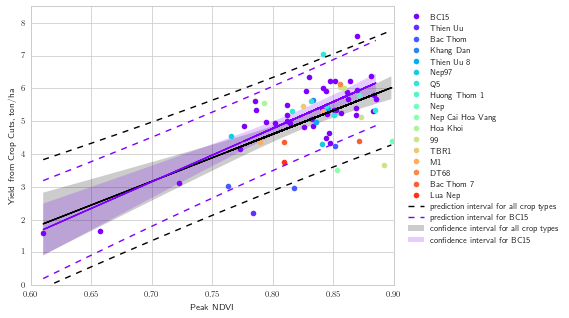

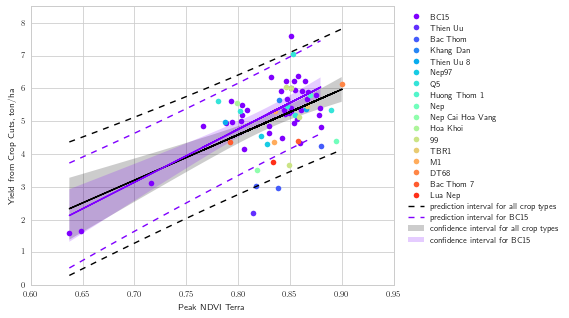

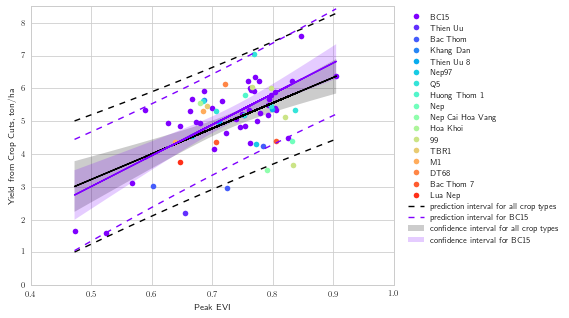

In [81]:
use_plotly = False
figsize = (6.5, 5)
# Constrained quad fitting, 1x1 crop, univariate linear regression

# fitting approach
# fit_func = fitLinODR
# fit_func = fitLinOLS
# fit_func = statsLinOLS
# fit_func = fitExpOLS
fit_func = rLinOLS

# select_ts_idx = [0, 1, 2]
select_ts_idx = range(len(ts_data_list))

for ts_idx in select_ts_idx:
    print "============================"
    print "For Time Series Type {0:s}\n".format(ts_data_label_list[ts_idx])
    ts_data = ts_data_list[ts_idx]
    peak_x_cst = peak_x_cst_list[ts_idx]
    peak_y_cst = peak_y_cst_list[ts_idx]
    
    cond_list = (peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
                 peak_y_cst.loc[ts_data.index] > 0, 
                 single_crop_pix_flag.loc[ts_data.index],
                 single_pix_subp_flag.loc[ts_data.index], 
                 pix_frac_flag.loc[ts_data.index], 
                 # np.logical_not(np.isnan(crop_yield_weight.loc[ts_data.index, 'wt_s'])), 
                 # peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
                 np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
    #              np.logical_not(np.in1d(ts_data.index, ['011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
                 np.ones(len(ts_data.index), dtype=np.bool))
    valid_flag = reduce(np.logical_and, cond_list)
    valid_ind = np.where(valid_flag)[0]
    valid_keys = ts_data.index.values[valid_ind]
    print "Number of valid subplots from our filtering = {0:d}\n".format(len(valid_keys))

    # select some data points not included in our regression to visually inspect 
    # their potential impact on our regression. 
    compare_keys_list = []
    # cond_list = (peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
    #              peak_y_cst.loc[ts_data.index] > 0,     
    #              single_crop_pix_flag.loc[ts_data.index],
    #              single_pix_subp_flag.loc[ts_data.index], 
    #              pix_frac_flag.loc[ts_data.index], 
    #              # peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
    #              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
    #              np.ones(len(ts_data.index), dtype=np.bool))
    # cp_flag = reduce(np.logical_and, cond_list)
    # compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])
    # cond_list = (peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
    #              peak_y_cst.loc[ts_data.index] > 0,     
    #              single_crop_pix_flag.loc[ts_data.index],
    #              single_pix_subp_flag.loc[ts_data.index], 
    #              pix_frac_flag.loc[ts_data.index], 
    #              # peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
    #              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
    #              np.ones(len(ts_data.index), dtype=np.bool))
    # cp_flag = reduce(np.logical_and, cond_list)
    # compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

    x = peak_y_cst.loc[valid_keys].values
    y = crop_yield_field.loc[valid_keys, 'yield_field'].values
    x_std = peak_y_std_cst.loc[valid_keys].values
    # y_wt = crop_yield_weight.loc[valid_keys, 'wt_s'].values
    # y_wt = y_wt/np.sum(y_wt)
    y_wt = np.ones_like(y)
    
    xvar_label = ["Peak {0:s}".format(ts_data_label_list[ts_idx])]

    if len(compare_keys_list) > 0:
        compare_x_list = [peak_y_cst.loc[cpkeys].values
                          for cpkeys in compare_keys_list]
        compare_y_list = [crop_yield_field.loc[cpkeys, 'yield_field'].values
                          for cpkeys in compare_keys_list]
        compare_marker_list = [mpl.markers.MarkerStyle.filled_markers[i] for i in range(len(compare_keys_list))]
        print "Number of data points to compare:"
        print [len(cpkeys) for cpkeys in compare_keys_list]

    coef, r2, xfit, yfit, mfunc, mfunc_unc = fit_func(x, y, x_std=x_std, y_std=1./y_wt)
    if coef is None:
        print "Fitting failed", str(fit_func)
    else:
        print "Model parameters: ", coef, str(fit_func)
        print "R2 = {0[0]:.3f}, Adjusted R2 = {0[1]:.3f}, AIC={0[2]:.3f}\n".format(r2) 
        rmse = np.sqrt(np.sum((mfunc(x) - y)**2)/len(y))
        print "RMSE = {0:.3f}, Relative RMSE = {1:.3f}\n".format(rmse, rmse/np.mean(y))

    crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
    n_crop_type = len(crop_type)
    print "Number of Crop Type = ", n_crop_type
    cmap = plt.get_cmap("rainbow")
    crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)    

    ndim = 1
    xdata = pd.DataFrame(x[np.newaxis, :], columns=valid_keys)
    ydata = pd.Series(y, index=valid_keys)
    wtdata = pd.Series(y_wt, index=valid_keys)
    xfit = xfit[np.newaxis, :]
    for i in range(ndim):
        fig, ax = plt.subplots(figsize=figsize)
        for ct in crop_type:
            tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
            ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
                    'o', color=crop_type_color.loc[ct], 
                    label='{0:s}'.format(str(ct)))

            if ct == "BC15":
                # fit for crop type BC15, the most abundant one
                ct_coef, ct_r2, ct_xfit, ct_yfit, \
                    ct_mfunc, ct_mfunc_unc = fit_func(xdata.loc[i, tmp_keys].values, ydata.loc[tmp_keys].values, 
                                                      y_std=1./wtdata.loc[tmp_keys].values)
                print "R2 for {2:d} of {0:s} = {1[0]:.3f}, Adjusted R2 = {1[1]:.3f}, AIC={1[2]:.3f}\n".format(ct, ct_r2, len(tmp_keys))
                ct_rmse = np.sqrt(np.sum((ct_mfunc(xdata.loc[i, tmp_keys].values) 
                                          - ydata.loc[tmp_keys].values)**2)/len(ydata.loc[tmp_keys].values))
                print "RMSE of {0:s} = {1:.3f}, Relative RMSE = {2:.3f}\n".format(ct, ct_rmse, ct_rmse/np.mean(ydata.loc[tmp_keys].values)), 
        if yfit is not None:
            ax.plot(xfit[i, :], yfit, '-k')
        # plot extra select data points to compare
        if len(compare_keys_list) > 0:
            for cpi, (cpkeys, cpx, cpy, cpmarker) \
                in enumerate(itertools.izip(compare_keys_list,
                                            compare_x_list, 
                                            compare_y_list, 
                                            compare_marker_list)):
                ax.plot(cpx, cpy, color="k", marker=cpmarker, linestyle="none", 
                        alpha=0.4, markersize=10, 
                        label="compare data {0:d}".format(cpi))
        # plot the regression line from the singled-out crop type
        ax.plot(ct_xfit, ct_yfit, linestyle="-", color=crop_type_color.loc["BC15"])
        # plot the uncertainty, one std_dev of the regression line
        tmpx = np.arange(np.min(x), np.max(x), (np.max(x)-np.min(x))/1e3)
        tmpy = mfunc(tmpx)
        tmpy_ci = mfunc_unc[0](tmpx)
        tmpy_pi = mfunc_unc[1](tmpx)
        ct_tmpx = np.arange(np.min(ct_xfit), np.max(ct_xfit), (np.max(ct_xfit)-np.min(ct_xfit))/1e3)
        ct_tmpy = ct_mfunc(ct_tmpx)
        ct_tmpy_ci = ct_mfunc_unc[0](ct_tmpx)
        ct_tmpy_pi = ct_mfunc_unc[1](ct_tmpx)

        plt.setp(ax, 
                 xlabel="{0:s}".format(xvar_label[i]), 
                 ylabel="Yield from Crop Cuts, ton/ha", 
                 ylim=(0, 8.5))
        if use_plotly:
            ax.plot(tmpx, tmpy_ci[:, 1], '-k', linewidth=0.05)
            ax.plot(tmpx, tmpy_ci[:, 2], '-k', linewidth=0.05)
            ax.plot(tmpx, tmpy_pi[:, 1], '--k')
            ax.plot(tmpx, tmpy_pi[:, 2], '--k')
            ax.plot(ct_tmpx, ct_tmpy_ci[:, 1], linestyle="-", color=crop_type_color.loc["BC15"], linewidth=0.05)
            ax.plot(ct_tmpx, ct_tmpy_ci[:, 2], linestyle="-", color=crop_type_color.loc["BC15"], linewidth=0.05)
            ax.plot(ct_tmpx, ct_tmpy_pi[:, 1], linestyle="--", color=crop_type_color.loc["BC15"])
            ax.plot(ct_tmpx, ct_tmpy_pi[:, 2], linestyle="--", color=crop_type_color.loc["BC15"])

            plotly_fig = plotly.tools.mpl_to_plotly(fig)
            plotly_fig['layout']['showlegend'] = True
            plotly_fig['data'][-3]['fill'] = "tonexty"
            plotly_fig['data'][-7]['fill'] = "tonexty"
            for ict, ct in enumerate(crop_type):
                tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
                plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
            for cpi, cpkeys in enumerate(compare_keys_list):
                plotly_fig['data'][n_crop_type+1+cpi]['text'] = ["{0:s}".format(k) for k in cpkeys]
            iplot(plotly_fig)
        else:
            ax.fill_between(tmpx, tmpy_ci[:, 1], tmpy_ci[:, 2], 
                            facecolor='k', alpha=0.2, edgecolor="None", linewidth=None, 
                            label="confidence interval for all crop types")
            ax.plot(tmpx, tmpy_pi[:, 1], '--k', label="prediction interval for all crop types")
            ax.plot(tmpx, tmpy_pi[:, 2], '--k')
            ax.fill_between(ct_tmpx, ct_tmpy_ci[:, 1], ct_tmpy_ci[:, 2], 
                            facecolor=crop_type_color.loc["BC15"], alpha=0.2, 
                            edgecolor="None", linewidth=None, 
                            label="confidence interval for BC15")
            ax.plot(ct_tmpx, ct_tmpy_pi[:, 1], linestyle="--", color=crop_type_color.loc["BC15"], 
                    label="prediction interval for BC15")
            ax.plot(ct_tmpx, ct_tmpy_pi[:, 2], linestyle="--", color=crop_type_color.loc["BC15"])
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
            plt.savefig("../figures/univar_linreg_crop_yield_vs_{0:s}.png".format(xvar_label[i].lower().replace(" ", "_")), 
                        dpi=dpi, bbox_inches="tight", pad_inches=0.)

## Training and Testing Using Leave-One-Out Cross Validation (LOOCV)

### Constrained quad fitting, 1x1 crop, univariate linear regression

For Time Series Type NDVI
Number of valid subplots from our filtering = 71
71 available LOO from 71 data points
LOOCV RMSE = 0.868
LOOCV RMSE/Mean = 0.172
R-square = 0.367, Adjusted R2 = 0.358
Number of Crop Type =  17
For Time Series Type NDVI Terra
Number of valid subplots from our filtering = 71
71 available LOO from 71 data points
LOOCV RMSE = 0.915
LOOCV RMSE/Mean = 0.181
R-square = 0.297, Adjusted R2 = 0.287
Number of Crop Type =  17
For Time Series Type EVI
Number of valid subplots from our filtering = 71
71 available LOO from 71 data points
LOOCV RMSE = 0.947
LOOCV RMSE/Mean = 0.188
R-square = 0.248, Adjusted R2 = 0.237
Number of Crop Type =  17


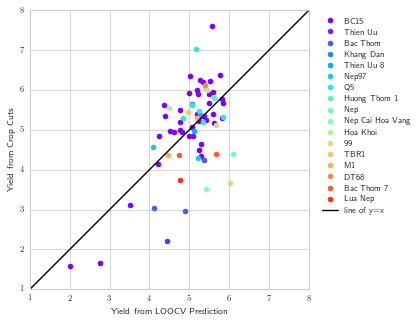

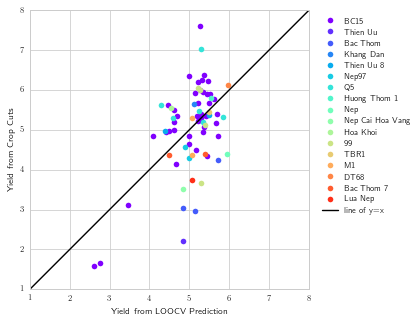

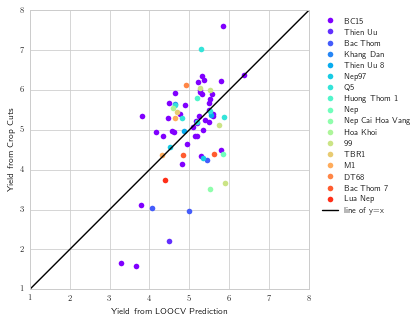

In [44]:
use_plotly = False
figsize = (6.5, 5)
# Constrained quad fitting, 1x1 crop, univariate linear regression

# fitting approach
# fit_func = fitLinODR
fit_func = fitLinOLS
# fit_func = fitExpOLS

# select_ts_idx = [0, 1, 2]
select_ts_idx = range(len(ts_data_list))

for ts_idx in select_ts_idx:
    print "For Time Series Type {0:s}".format(ts_data_label_list[ts_idx])
    ts_data = ts_data_list[ts_idx]
    peak_x_cst = peak_x_cst_list[ts_idx]
    peak_y_cst = peak_y_cst_list[ts_idx]
    
    cond_list = (peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
                 peak_y_cst.loc[ts_data.index] > 0, 
                 single_crop_pix_flag.loc[ts_data.index],
                 single_pix_subp_flag.loc[ts_data.index], 
                 pix_frac_flag.loc[ts_data.index], 
                 # peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
                 # crop_yield_field.loc[ts_data.index, 'variety']=="BC15", 
                 np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
    #              np.logical_not(np.in1d(ts_data.index, ['011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
                 np.ones(len(ts_data.index), dtype=np.bool))
    valid_flag = reduce(np.logical_and, cond_list)
    valid_ind = np.where(valid_flag)[0]
    valid_keys = ts_data.index.values[valid_ind]
    print "Number of valid subplots from our filtering = {0:d}".format(len(valid_keys))

    valid_x = peak_y_cst.loc[valid_keys]
    valid_y = crop_yield_field.loc[valid_keys, 'yield_field']
    valid_x_std = peak_y_std_cst.loc[valid_keys]
    ndim  = 1 if valid_x.size==valid_x.shape[0] else valid_x.shape[0]

    nvalid = len(valid_keys)
    loo_y = pd.Series(np.zeros(nvalid), index=valid_keys)
    loo_r2 = pd.Series(np.zeros(nvalid), index=valid_keys)
    loo_adjr2 = pd.Series(np.zeros(nvalid), index=valid_keys)
    for i, loo_key in enumerate(valid_keys):
        curr_keys = valid_keys[np.where(np.logical_not(np.in1d(valid_keys, loo_key)))[0]]
        x = valid_x.loc[curr_keys].values
        y = valid_y.loc[curr_keys].values
        x_std = valid_x_std.loc[curr_keys].values
        coef, r2, xfit, yfit, mfunc, mfunc_unc = fit_func(x, y, x_std=x_std)
        if coef is None:
            print "Fitting failed with {0:s} as LOO with fitting function {1:s}".format(loo_key, str(fit_func))
            loo_y.loc[loo_key] = np.nan
            loo_r2.loc[loo_key] = np.nan
        else:
            loo_y.loc[loo_key] = mfunc(valid_x.loc[loo_key])
            loo_r2.loc[loo_key] = r2[0]
            loo_adjr2.loc[loo_key] = r2[1]

    # Calculate the LOOCV RMSE and R2
    avail_keys = valid_keys[np.where(np.logical_not(np.isnan(loo_y)))[0]]
    print "{0:d} available LOO from {1:d} data points".format(len(avail_keys), nvalid)
    loocv_rmse = np.sqrt(np.sum(np.abs(loo_y.loc[avail_keys] - valid_y.loc[avail_keys])**2)/float(len(avail_keys)))
    print "LOOCV RMSE = {0:.3f}".format(loocv_rmse)
    print "LOOCV RMSE/Mean = {0:.3f}".format(loocv_rmse/np.mean(valid_y.loc[avail_keys]))

    loocv_r2 = 1 - np.sum((valid_y.loc[avail_keys] - loo_y.loc[avail_keys])**2) / np.sum((valid_y.loc[avail_keys]-np.mean(valid_y.loc[avail_keys]))**2)
    loocv_adjr2 = 1 - (1-loocv_r2) * (float(valid_y.loc[avail_keys].size)-1) / (float(valid_y.loc[avail_keys].size)-ndim-1)
    print "R-square = {0:.3f}, Adjusted R2 = {1:.3f}".format(loocv_r2, loocv_adjr2)

    # plot LOOCV modeled y against data y
    crop_type = crop_yield_field.loc[avail_keys, 'variety'].unique()
    n_crop_type = len(crop_type)
    print "Number of Crop Type = ", n_crop_type
    cmap = plt.get_cmap("rainbow")
    crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)

    fig, ax = plt.subplots(figsize=figsize)
    for ct in crop_type:
        tmp_keys = [k for k in avail_keys if crop_yield_field.loc[k, "variety"]==ct]
        ax.plot(loo_y.loc[tmp_keys], valid_y.loc[tmp_keys], 
                'o', color=crop_type_color.loc[ct], 
                label='{0:s}'.format(str(ct)))
    # plot one-to-one line
    xlb, xub = ax.get_xlim()
    ylb, yub = ax.get_ylim()
    lb = (xlb if xlb < ylb else ylb)
    ub = (xub if xub > yub else yub)
    ax.plot([lb, ub], [lb, ub], '-k', label="line of y=x")
    plt.setp(ax, aspect="equal", xlim=(lb, ub), ylim=(lb, ub), 
             xlabel="Yield from LOOCV Prediction", 
             ylabel="Yield from Crop Cuts")
    if use_plotly:
        plotly_fig = plotly.tools.mpl_to_plotly(fig)
        plotly_fig['layout']['showlegend'] = True
        for ict, ct in enumerate(crop_type):
            tmp_keys = [k for k in avail_keys if crop_yield_field.loc[k, "variety"]==ct]
            plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
        iplot(plotly_fig)
    else:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
        plt.savefig("../figures/loocv_crop_yield_field_vs_prediction_by_ts_{0:s}.png".format(ts_data_label_list[ts_idx].lower().replace(" ", "_")), 
                    dpi=dpi, bbox_inches="tight", pad_inches=0.)

## Weirdo subplots with unusually low crop yield
* ['011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02']

## Weirdo subplots with unusually high crop yield
* ['072557-p10', '072557-p04', '072557-p13', '072557-p02']

## Examine the time series of the found weirdos 

In [45]:
# # examine the time series of the found weirdos 

# # select_keys = ['065186-p06', '015361-p17', '034300-p21']
# # select_keys = ['072557-p10', '072557-p04', '072557-p13', '072557-p02', '012748-p04']
# # select_keys = ['004622-p10', '018619-p05', '020258-p03', '038505-p01', '011504-p05']
# # select_keys = ['011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02']
# select_keys = ['015361-p10', '015625-p14', '017127-p02', '017745-p01',
#        '018619-p01', '018619-p05', '020258-p03', '024047-p03',
#        '024047-p12', '024847-p01', '024847-p07', '024847-p24',
#        '025021-p19', '025236-p03', '038505-p01', '038505-p07',
#        '038505-p18', '039190-p05', '039753-p06', '043388-p03',
#        '043402-p09', '043402-p20', '043716-p03', '055628-p05']
# # select_keys = np.concatenate((np.random.choice(valid_keys, 3, replace=False), compare_keys_list[0]))

# select_ind = np.where(np.in1d(ts_data.index, select_keys))[0]
# select_max_y = max_y_cst.loc[select_keys]


# # print peak_y_std_cst.loc[select_keys]
# # print peak_y_cst.loc[select_keys] + 3*peak_y_std_cst.loc[select_keys]
# # print max_y_cst.loc[select_keys]

# use_plotly=True
# for i, k, ymv in zip(select_ind, select_keys, select_max_y):
# #     fit_output = quadPeakConstrained(ts_data, k, beg_doy, end_doy)

#     if use_plotly:
#         fig, ax = plt.subplots(figsize=(9, 2.5))
        
#         y = ts_data.loc[k, :].copy()
#         x = y.index.values
#         y = y.values
#         tmp_ind = np.where(y != no_data)[0]
#         x = x[tmp_ind]
#         y = y[tmp_ind]
#         ax.plot(x, y, '.r')

#         ts_section = ts_data.loc[k, beg_doy:end_doy].copy()
#         tmp_ind = np.where(ts_section != no_data)[0]
#         y = ts_section.values[tmp_ind]
#         x = ts_section.index.values[tmp_ind]
#         xfit = np.arange(beg_doy, end_doy)
#         ax.plot(xfit, quad_func_cst[k](xfit), '-g', label="constrained")
#         ax.plot([beg_doy, end_doy], [ymv, ymv], '-k')

#         plt.setp(ax, title=k, xlabel='DOY', ylabel='Value', 
#                  xlim=(0, 366)) 
        
#         plotly_fig = plotly.tools.mpl_to_plotly(fig)
#         iplot(plotly_fig)
#     else:
#         fig = plt.figure(figsize=(10, 2.5))
#         ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
#         ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

#         y = ts_data.loc[k, :].copy()
#         x = y.index.values
#         y = y.values
#         tmp_ind = np.where(y != no_data)[0]
#         x = x[tmp_ind]
#         y = y[tmp_ind]
#         ax1.plot(x, y, '.r')
#         plt.setp(ax1, title=k, xlabel='DOY', ylabel='Value', 
#                  xlim=(0, 366)) 

#         ts_section = ts_data.loc[k, beg_doy:end_doy].copy()
#         tmp_ind = np.where(ts_section != no_data)[0]
#         y = ts_section.values[tmp_ind]
#         x = ts_section.index.values[tmp_ind]
#         ax2.plot(x, y, '.r')
#         xfit = np.arange(beg_doy, end_doy)
#         ax2.plot(xfit, quad_func_cst[k](xfit), '-g', label="constrained")
#         ax2.plot([beg_doy, end_doy], [ymv, ymv], '-k')
#         plt.setp(ax2, title=k, xlabel='DOY')

## Constrained quad fitting, 3x3 crop, multivariate linear regression

In [46]:
# use_plotly = True
# # Constrained quad fitting, 3x3 crop, multivariate linear regression

# # fitting approach
# fit_func = fitMLinOLS

# cond_list = (# peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
#              peak_y_cst.loc[ts_data.index] > 0,     
#              crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index], 
#              pix_frac_flag.loc[ts_data.index], 
#              peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# valid_flag = reduce(np.logical_and, cond_list)
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
# print np.sum(crop_pix_flag)
# print len(valid_keys)

# # select some data points not included in our regression to visually inspect 
# # their potential impact on our regression. 
# compare_keys_list = []
# cond_list = (# peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
#              peak_y_cst.loc[ts_data.index] > 0,     
#              crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index], 
#              # pix_frac_flag.loc[ts_data.index], 
#              peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])
# cond_list = (# peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy,
#              peak_y_cst.loc[ts_data.index] > 0,     
#              crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index], 
#              pix_frac_flag.loc[ts_data.index], 
#              # peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

# x = np.array([quad_coef_cst.loc[valid_keys].values, 
#               peak_x_cst.loc[valid_keys].values, 
#               peak_y_cst.loc[valid_keys].values])
# y = crop_yield_field.loc[valid_keys, 'yield_field'].values

# if len(compare_keys_list) > 0:
#     compare_x_list = [np.array([quad_coef_cst.loc[cpkeys].values, 
#                                 peak_x_cst.loc[cpkeys].values, 
#                                 peak_y_cst.loc[cpkeys].values]) 
#                       for cpkeys in compare_keys_list]
#     compare_y_list = [crop_yield_field.loc[cpkeys, 'yield_field'].values
#                       for cpkeys in compare_keys_list]
#     compare_marker_list = [mpl.markers.MarkerStyle.filled_markers[i] for i in range(len(compare_keys_list))]
#     print "Number of data points to compare:"
#     print [len(cpkeys) for cpkeys in compare_keys_list]

# coef, r2, xfit, yfit = fit_func(x, y)
# if coef is None:
#     print "Fitting failed", str(fit_func)
# else:
#     print "Model parameters: ", coef, str(fit_func)
#     print "R-square: ", r2 
    
# crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
# n_crop_type = len(crop_type)
# print "Number of Crop Type = ", n_crop_type
# cmap = plt.get_cmap("rainbow")
# crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)

# ndim = x.shape[0]
# xdata = pd.DataFrame(x, columns=valid_keys)
# ydata = pd.Series(y, index=valid_keys)
# for i in range(ndim):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for ct in crop_type:
#         tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#         ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
#                 '.', color=crop_type_color.loc[ct], 
#                 label='pixel of subplot is crop {0:s}'.format(str(ct)))
#     if yfit is not None:
#         ax.plot(xfit[i, :], yfit, '*k')
#     # plot extra select data points to compare
#     if len(compare_keys_list) > 0:
#         for cpi, (cpkeys, cpx, cpy, cpmarker) \
#             in enumerate(itertools.izip(compare_keys_list,
#                                         compare_x_list, 
#                                         compare_y_list, 
#                                         compare_marker_list)):
#             ax.plot(cpx[i, :], cpy, color="k", marker=cpmarker, linestyle="none", 
#                     alpha=0.4, 
#                     label="compare data {0:d}".format(cpi))
            
#     plt.setp(ax, xlabel="variable {0:d}".format(i), ylabel="crop yield")
#     if use_plotly:
#         plotly_fig = plotly.tools.mpl_to_plotly(fig)
#         plotly_fig['layout']['showlegend'] = True
#         for ict, ct in enumerate(crop_type):
#             tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#             plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
#         iplot(plotly_fig)

## Constrained quad fitting, 3x3 crop, univariate linear regression

In [47]:
# use_plotly = True
# # Constrained quad fitting, 3x3 crop, univariate linear regression

# # fitting approach
# # fit_func = fitLinODR
# fit_func = fitLinOLS
# # fit_func = fitExpOLS

# cond_list = (# peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
#              peak_y_cst.loc[ts_data.index] > 0,     
#              crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index], 
#              pix_frac_flag.loc[ts_data.index], 
#              peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# valid_flag = reduce(np.logical_and, cond_list)
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
# print np.sum(crop_pix_flag)
# print len(valid_keys)

# # select some data points not included in our regression to visually inspect 
# # their potential impact on our regression. 
# compare_keys_list = []
# cond_list = (# peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
#              peak_y_cst.loc[ts_data.index] > 0,     
#              crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index], 
#              # pix_frac_flag.loc[ts_data.index], 
#              peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])
# cond_list = (# peak_x_cst.loc[ts_data.index]>beg_doy, peak_x_cst.loc[ts_data.index]<end_doy, 
#              peak_y_cst.loc[ts_data.index] > 0,     
#              crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index], 
#              pix_frac_flag.loc[ts_data.index], 
#              # peak_y_cst.loc[ts_data.index]+3*peak_y_std_cst.loc[ts_data.index]>max_y_cst.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

# x = peak_y_cst.loc[valid_keys].values
# y = crop_yield_field.loc[valid_keys, 'yield_field'].values
# x_std = peak_y_std_cst.loc[valid_keys].values

# if len(compare_keys_list) > 0:
#     compare_x_list = [peak_y_cst.loc[cpkeys].values
#                       for cpkeys in compare_keys_list]
#     compare_y_list = [crop_yield_field.loc[cpkeys, 'yield_field'].values
#                       for cpkeys in compare_keys_list]
#     compare_marker_list = [mpl.markers.MarkerStyle.filled_markers[i] for i in range(len(compare_keys_list))]
#     print "Number of data points to compare:"
#     print [len(cpkeys) for cpkeys in compare_keys_list]

# coef, r2, xfit, yfit = fit_func(x, y, x_std=x_std)
# if coef is None:
#     print "Fitting failed", str(fit_func)
# else:
#     print "Model parameters: ", coef, str(fit_func)
#     print "R-square: ", r2      

# crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
# n_crop_type = len(crop_type)
# print "Number of Crop Type = ", n_crop_type
# cmap = plt.get_cmap("rainbow")
# crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)    
    
# ndim = 1
# xdata = pd.DataFrame(x[np.newaxis, :], columns=valid_keys)
# ydata = pd.Series(y, index=valid_keys)
# xfit = xfit[np.newaxis, :]
# for i in range(ndim):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for ct in crop_type:
#         tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#         ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
#                 '.', color=crop_type_color.loc[ct], 
#                 label='pixel of subplot is crop {0:s}'.format(str(ct)))
#     if yfit is not None:
#         ax.plot(xfit[i, :], yfit, '-k')
#     # plot extra select data points to compare
#     if len(compare_keys_list) > 0:
#         for cpi, (cpkeys, cpx, cpy, cpmarker) \
#             in enumerate(itertools.izip(compare_keys_list,
#                                         compare_x_list, 
#                                         compare_y_list, 
#                                         compare_marker_list)):
#             ax.plot(cpx, cpy, color="k", marker=cpmarker, linestyle="none", 
#                     alpha=0.4, 
#                     label="compare data {0:d}".format(cpi))
            
#     plt.setp(ax, xlabel="variable {0:d}".format(i), ylabel="crop yield")
#     if use_plotly:
#         plotly_fig = plotly.tools.mpl_to_plotly(fig)
#         plotly_fig['layout']['showlegend'] = True
#         for ict, ct in enumerate(crop_type):
#             tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#             plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
#         iplot(plotly_fig)

## Output results to CSV for ADB

In [48]:
# out_df4adb = crop_yield_field.copy()

# out_df4adb.loc[:, 'crop_pixel_flag'] = pd.Series(np.zeros(len(out_df4adb), dtype=np.bool), index=out_df4adb.index)
# out_df4adb.loc[single_crop_pix_flag.index, 'crop_pixel_flag'] = single_crop_pix_flag.loc[:]

# out_df4adb.loc[:, 'single_pixel_flag'] = pd.Series(np.zeros(len(out_df4adb), dtype=np.bool), index=out_df4adb.index)
# out_df4adb.loc[single_pix_subp_flag.index, 'single_pixel_flag'] = single_pix_subp_flag.loc[:]

# out_df4adb.loc[:, 'landsat_geo_flag'] = pd.Series(np.zeros(len(out_df4adb), dtype=np.bool), index=out_df4adb.index)
# out_df4adb.loc[pix_frac_flag.index, 'landsat_geo_flag'] = pix_frac_flag.loc[:]

# select_ts_idx = [0, 2]

# # get the subplot ids that we used in our regression
# ts_data = ts_data_list[select_ts_idx[0]]
# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index], 
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# valid_flag = reduce(np.logical_and, cond_list)
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]

# select_for_reg_keys = valid_keys

# out_df4adb.loc[:, 'select_for_reg_flag'] = pd.Series(np.zeros(len(out_df4adb), dtype=np.bool), index=out_df4adb.index)
# out_df4adb.loc[select_for_reg_keys, 'select_for_reg_flag'] = True

# # output peak of time series fitting
# for ts_idx in select_ts_idx:
#     tmp_label = "fit_peak_{0:s}".format(ts_data_label_list[ts_idx].lower().replace(" ", "_"))
#     out_df4adb.loc[:, tmp_label] = pd.Series(np.zeros(len(out_df4adb))+np.nan, index=out_df4adb.index)
#     out_df4adb.loc[peak_y_cst_list[ts_idx].index, tmp_label] = peak_y_cst_list[ts_idx].loc[:]

#     tmp_label = "fit_peak_std_{0:s}".format(ts_data_label_list[ts_idx].lower().replace(" ", "_"))
#     out_df4adb.loc[:, tmp_label] = pd.Series(np.zeros(len(out_df4adb))+np.nan, index=out_df4adb.index)
#     out_df4adb.loc[peak_y_std_cst_list[ts_idx].index, tmp_label] = peak_y_std_cst_list[ts_idx].loc[:]

# out_df4adb = out_df4adb.rename(index=str, columns={'lat_m':'lat_mesh', 'lon_m':'lon_mesh', 'lat_s':'lat_subplot', 'lon_s':'lon_subplot'})
# # write to csv
# out_csv4adb = "../results/thai_binh_crop_fit_peak_vi.csv"
# with open(out_csv4adb, 'w') as fobj:
#     fobj.write("# crop_pixel_flag: if the center of the subplot is in a crop pixel according to our classification.\n")
#     fobj.write("# single_pixel_flag: if the subplot is entirely within a single Landsat pixel.\n")
#     fobj.write("# landsat_geo_flag: if the four sides of the subplot are away from the four sides of the pixel it locates for at least 5.7 m, the geolocation RMSE of our Landsat images.\n")
#     fobj.write("# select_for_reg_flag: if the subplot is selected in final regression.\n")
#     for ts_idx in select_ts_idx:
#         ts_label = ts_data_label_list[ts_idx]
#         tmp_label = "fit_peak_{0:s}".format(ts_label.lower().replace(" ", "_"))
#         fobj.write("# {0:s}: peak estimate of {1:s} by temporal fitting.\n".format(tmp_label, ts_label))
#         tmp_label = "fit_peak_std_{0:s}".format(ts_label.lower().replace(" ", "_"))
#         fobj.write("# {0:s}: standard deviation of peak estimate of {1:s} by temporal fitting.\n".format(tmp_label, ts_label))
        
# with open(out_csv4adb, 'a') as fobj:
#     out_df4adb.to_csv(fobj)

# # out_df4adb.to_csv("../results/thai_binh_crop_fit_peak_vi.csv")

## Simple stats of time series section for crop yield modeling

In [49]:
# use_plotly = True

# # fitting approach
# # fit_func = fitLinODR
# fit_func = fitLinOLS
# # fit_func = fitExpOLS

# # Simple stats, e.g maximum, mean or median, from given temporal window
# beg_doy = 240
# end_doy = 260

# stats_func = np.nanmax

# valid_flag = reduce(np.logical_and, (crop_pix_flag.loc[ts_data.index], 
#                                      pix_frac_flag.loc[ts_data.index], 
#                                      single_pix_subp_flag.loc[ts_data.index]))
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
# print np.sum(crop_pix_flag)
# print len(valid_keys)

# ts_data_nan = ts_data.loc[valid_keys, :].replace(no_data, np.nan)
# x = stats_func(ts_data_nan, axis=1)
# tmp_flag = np.logical_not(np.isnan(x))
# x = x[tmp_flag]
# valid_keys = valid_keys[tmp_flag]
# print "Available subplots for simple stats = ", len(valid_keys)
# valid_x = pd.Series(x, valid_keys)
# y = crop_yield_field.loc[valid_keys, 'yield_field'].values
# valid_y = pd.Series(y, valid_keys)

# coef, r2, xfit, yfit = fit_func(x, y, x_std=peak_y_std_cst.loc[valid_keys].values)
# if coef is None:
#     print "Fitting failed", str(fit_func)
# else:
#     print "Model parameters: ", coef, str(fit_func)
#     print "R-square: ", r2      

# ndim = 1
# xdata = pd.DataFrame(x[np.newaxis, :], columns=valid_x.index)
# ydata = pd.Series(y, index=valid_y.index)
# xfit = xfit[np.newaxis, :]
# for i in range(ndim):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for ct in crop_type:
#         tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#         ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
#                 '.', color=crop_type_color.loc[ct], 
#                 label='pixel of subplot is crop {0:s}'.format(str(ct)))
#     if yfit is not None:
#         ax.plot(xfit[i, :], yfit, '-k')
#     plt.setp(ax, xlabel="variable {0:d}".format(i), ylabel="crop yield")
#     if use_plotly:
#         plotly_fig = plotly.tools.mpl_to_plotly(fig)
#         plotly_fig['layout']['showlegend'] = True
#         for ict, ct in enumerate(crop_type):
#             tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#             plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
#         iplot(plotly_fig)

## Plot NDVI SG fit peak against cropy yield

In [50]:
# del ts_data
# ts_data = ts_ndvi_sg.copy()

# use_plotly = True
# # Constrained quad fitting, 1x1 crop, univariate linear regression

# # Simple stats, e.g maximum, mean or median, from given temporal window
# beg_doy = 240
# end_doy = 260

# stats_func = np.nanmax

# simple_stats_x = stats_func(ts_data.replace(no_data, np.nan), axis=1)
# simple_stats_x = pd.Series(simple_stats_x, index=ts_data.index)

# # fitting approach
# # fit_func = fitLinODR
# fit_func = fitLinOLS
# # fit_func = fitExpOLS

# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02', 
#                                                     '011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# valid_flag = reduce(np.logical_and, cond_list)
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
# print np.sum(single_crop_pix_flag)
# print len(valid_keys)

# # select some data points not included in our regression to visually inspect 
# # their potential impact on our regression. 
# compare_keys_list = []
# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])
# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

# ts_data_nan = ts_data.loc[valid_keys, :].replace(no_data, np.nan)
# x = stats_func(ts_data_nan, axis=1)
# tmp_flag = np.logical_not(np.isnan(x))
# x = x[tmp_flag]
# valid_keys = valid_keys[tmp_flag]
# print "Available subplots for simple stats = ", len(valid_keys)
# y = crop_yield_field.loc[valid_keys, 'yield_field'].values
# valid_x = pd.Series(x, valid_keys)
# valid_y = pd.Series(y, valid_keys)

# if len(compare_keys_list) > 0:
#     compare_x_list = [simple_stats_x.loc[cpkeys].values
#                       for cpkeys in compare_keys_list]
#     compare_y_list = [crop_yield_field.loc[cpkeys, 'yield_field'].values
#                       for cpkeys in compare_keys_list]
#     compare_marker_list = [mpl.markers.MarkerStyle.filled_markers[i] for i in range(len(compare_keys_list))]
#     print "Number of data points to compare:"
#     print [len(cpkeys) for cpkeys in compare_keys_list]

# coef, r2, xfit, yfit, mfunc = fit_func(x, y)
# if coef is None:
#     print "Fitting failed", str(fit_func)
# else:
#     print "Model parameters: ", coef, str(fit_func)
#     print "R-square: ", r2      
#     print "RMSE = ", np.sqrt(np.sum((mfunc(x) - y)**2)/len(y))

# crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
# n_crop_type = len(crop_type)
# print "Number of Crop Type = ", n_crop_type
# cmap = plt.get_cmap("rainbow")
# crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)    
    
# ndim = 1
# xdata = pd.DataFrame(x[np.newaxis, :], columns=valid_keys)
# ydata = pd.Series(y, index=valid_keys)
# xfit = xfit[np.newaxis, :]
# for i in range(ndim):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for ct in crop_type:
#         tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#         ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
#                 '.', color=crop_type_color.loc[ct], 
#                 label='pixel of subplot is crop {0:s}'.format(str(ct)))
        
#         if ct == "BC15":
#             # fit for crop type BC15, the most abundant one
#             ct_coef, ct_r2, ct_xfit, ct_yfit, ct_mfunc = fit_func(xdata.loc[i, tmp_keys].values, ydata.loc[tmp_keys].values)
#             print "r2 for {2:d} of {0:s} = {1:f}".format(ct, ct_r2, len(tmp_keys))
#             print "RMSE of {0:s} = ".format(ct), np.sqrt(np.sum((ct_mfunc(xdata.loc[i, tmp_keys].values) \
#                                                                  - ydata.loc[tmp_keys].values)**2)/len(ydata.loc[tmp_keys].values))
#     if yfit is not None:
#         ax.plot(xfit[i, :], yfit, '-k')
#     # plot extra select data points to compare
#     if len(compare_keys_list) > 0:
#         for cpi, (cpkeys, cpx, cpy, cpmarker) \
#             in enumerate(itertools.izip(compare_keys_list,
#                                         compare_x_list, 
#                                         compare_y_list, 
#                                         compare_marker_list)):
#             ax.plot(cpx, cpy, color="k", marker=cpmarker, linestyle="none", 
#                     alpha=0.4, markersize=10, 
#                     label="compare data {0:d}".format(cpi))
#     ax.plot(ct_xfit, ct_yfit, linestyle="-", color=crop_type_color.loc["BC15"])
            
#     plt.setp(ax, xlabel="variable {0:d}".format(i), ylabel="crop yield")
#     if use_plotly:
#         plotly_fig = plotly.tools.mpl_to_plotly(fig)
#         plotly_fig['layout']['showlegend'] = True
#         for ict, ct in enumerate(crop_type):
#             tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#             plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
#         for cpi, cpkeys in enumerate(compare_keys_list):
#             plotly_fig['data'][n_crop_type+1+cpi]['text'] = ["{0:s}".format(k) for k in cpkeys]
#         iplot(plotly_fig)

## Plot SWIR1 and SWIR2 against Crop Yield

In [51]:
# del ts_data
# ts_data = ts_swir1_fuse_aq_merge.copy()

# use_plotly = True
# # Constrained quad fitting, 1x1 crop, univariate linear regression

# # Simple stats, e.g maximum, mean or median, from given temporal window
# beg_doy = 245
# end_doy = 255

# stats_func = np.nanmax

# simple_stats_x = stats_func(ts_data.replace(no_data, np.nan), axis=1)
# simple_stats_x = pd.Series(simple_stats_x, index=ts_data.index)

# # fitting approach
# # fit_func = fitLinODR
# fit_func = fitLinOLS
# # fit_func = fitExpOLS

# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02', 
#                                                     '011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# valid_flag = reduce(np.logical_and, cond_list)
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
# print np.sum(single_crop_pix_flag)
# print len(valid_keys)

# # select some data points not included in our regression to visually inspect 
# # their potential impact on our regression. 
# compare_keys_list = []
# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])
# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

# ts_data_nan = ts_data.loc[valid_keys, :].replace(no_data, np.nan)
# x = stats_func(ts_data_nan, axis=1)
# tmp_flag = np.logical_not(np.isnan(x))
# x = x[tmp_flag]
# valid_keys = valid_keys[tmp_flag]
# print "Available subplots for simple stats = ", len(valid_keys)
# y = crop_yield_field.loc[valid_keys, 'yield_field'].values
# valid_x = pd.Series(x, valid_keys)
# valid_y = pd.Series(y, valid_keys)

# if len(compare_keys_list) > 0:
#     compare_x_list = [simple_stats_x.loc[cpkeys].values
#                       for cpkeys in compare_keys_list]
#     compare_y_list = [crop_yield_field.loc[cpkeys, 'yield_field'].values
#                       for cpkeys in compare_keys_list]
#     compare_marker_list = [mpl.markers.MarkerStyle.filled_markers[i] for i in range(len(compare_keys_list))]
#     print "Number of data points to compare:"
#     print [len(cpkeys) for cpkeys in compare_keys_list]

# coef, r2, xfit, yfit, mfunc = fit_func(x, y)
# if coef is None:
#     print "Fitting failed", str(fit_func)
# else:
#     print "Model parameters: ", coef, str(fit_func)
#     print "R-square: ", r2      
#     print "RMSE = ", np.sqrt(np.sum((mfunc(x) - y)**2)/len(y))

# crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
# n_crop_type = len(crop_type)
# print "Number of Crop Type = ", n_crop_type
# cmap = plt.get_cmap("rainbow")
# crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)    
    
# ndim = 1
# xdata = pd.DataFrame(x[np.newaxis, :], columns=valid_keys)
# ydata = pd.Series(y, index=valid_keys)
# xfit = xfit[np.newaxis, :]
# for i in range(ndim):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for ct in crop_type:
#         tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#         ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
#                 '.', color=crop_type_color.loc[ct], 
#                 label='pixel of subplot is crop {0:s}'.format(str(ct)))
        
#         if ct == "BC15":
#             # fit for crop type BC15, the most abundant one
#             ct_coef, ct_r2, ct_xfit, ct_yfit, ct_mfunc = fit_func(xdata.loc[i, tmp_keys].values, ydata.loc[tmp_keys].values)
#             print "r2 for {2:d} of {0:s} = {1:f}".format(ct, ct_r2, len(tmp_keys))
#             print "RMSE of {0:s} = ".format(ct), np.sqrt(np.sum((ct_mfunc(xdata.loc[i, tmp_keys].values) \
#                                                                  - ydata.loc[tmp_keys].values)**2)/len(ydata.loc[tmp_keys].values))
#     if yfit is not None:
#         ax.plot(xfit[i, :], yfit, '-k')
#     # plot extra select data points to compare
#     if len(compare_keys_list) > 0:
#         for cpi, (cpkeys, cpx, cpy, cpmarker) \
#             in enumerate(itertools.izip(compare_keys_list,
#                                         compare_x_list, 
#                                         compare_y_list, 
#                                         compare_marker_list)):
#             ax.plot(cpx, cpy, color="k", marker=cpmarker, linestyle="none", 
#                     alpha=0.4, markersize=10, 
#                     label="compare data {0:d}".format(cpi))
#     ax.plot(ct_xfit, ct_yfit, linestyle="-", color=crop_type_color.loc["BC15"])
            
#     plt.setp(ax, xlabel="variable {0:d}".format(i), ylabel="crop yield")
#     if use_plotly:
#         plotly_fig = plotly.tools.mpl_to_plotly(fig)
#         plotly_fig['layout']['showlegend'] = True
#         for ict, ct in enumerate(crop_type):
#             tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#             plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
#         for cpi, cpkeys in enumerate(compare_keys_list):
#             plotly_fig['data'][n_crop_type+1+cpi]['text'] = ["{0:s}".format(k) for k in cpkeys]
#         iplot(plotly_fig)

In [52]:
# del ts_data
# ts_data = ts_swir2_fuse_aq_merge.copy()

# use_plotly = True
# # Constrained quad fitting, 1x1 crop, univariate linear regression

# # Simple stats, e.g maximum, mean or median, from given temporal window
# beg_doy = 245
# end_doy = 255

# stats_func = np.nanmax

# simple_stats_x = stats_func(ts_data.replace(no_data, np.nan), axis=1)
# simple_stats_x = pd.Series(simple_stats_x, index=ts_data.index)

# # fitting approach
# # fit_func = fitLinODR
# fit_func = fitLinOLS
# # fit_func = fitExpOLS

# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02', 
#                                                     '011504-p01', '011504-p05', '038849-p11', '038505-p01', '024047-p10', '024019-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# valid_flag = reduce(np.logical_and, cond_list)
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
# print np.sum(single_crop_pix_flag)
# print len(valid_keys)

# # select some data points not included in our regression to visually inspect 
# # their potential impact on our regression. 
# compare_keys_list = []
# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])
# cond_list = (single_crop_pix_flag.loc[ts_data.index],
#              single_pix_subp_flag.loc[ts_data.index],
#              pix_frac_flag.loc[ts_data.index], 
#              np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02'])), 
#              np.ones(len(ts_data.index), dtype=np.bool))
# cp_flag = reduce(np.logical_and, cond_list)
# compare_keys_list.append(ts_data.index.values[np.where(np.logical_xor(valid_flag, cp_flag))[0]])

# ts_data_nan = ts_data.loc[valid_keys, :].replace(no_data, np.nan)
# x = stats_func(ts_data_nan, axis=1)
# tmp_flag = np.logical_not(np.isnan(x))
# x = x[tmp_flag]
# valid_keys = valid_keys[tmp_flag]
# print "Available subplots for simple stats = ", len(valid_keys)
# y = crop_yield_field.loc[valid_keys, 'yield_field'].values
# valid_x = pd.Series(x, valid_keys)
# valid_y = pd.Series(y, valid_keys)

# if len(compare_keys_list) > 0:
#     compare_x_list = [simple_stats_x.loc[cpkeys].values
#                       for cpkeys in compare_keys_list]
#     compare_y_list = [crop_yield_field.loc[cpkeys, 'yield_field'].values
#                       for cpkeys in compare_keys_list]
#     compare_marker_list = [mpl.markers.MarkerStyle.filled_markers[i] for i in range(len(compare_keys_list))]
#     print "Number of data points to compare:"
#     print [len(cpkeys) for cpkeys in compare_keys_list]

# coef, r2, xfit, yfit, mfunc = fit_func(x, y)
# if coef is None:
#     print "Fitting failed", str(fit_func)
# else:
#     print "Model parameters: ", coef, str(fit_func)
#     print "R-square: ", r2      
#     print "RMSE = ", np.sqrt(np.sum((mfunc(x) - y)**2)/len(y))

# crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
# n_crop_type = len(crop_type)
# print "Number of Crop Type = ", n_crop_type
# cmap = plt.get_cmap("rainbow")
# crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)    
    
# ndim = 1
# xdata = pd.DataFrame(x[np.newaxis, :], columns=valid_keys)
# ydata = pd.Series(y, index=valid_keys)
# xfit = xfit[np.newaxis, :]
# for i in range(ndim):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for ct in crop_type:
#         tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#         ax.plot(xdata.loc[i, tmp_keys], ydata.loc[tmp_keys], 
#                 '.', color=crop_type_color.loc[ct], 
#                 label='pixel of subplot is crop {0:s}'.format(str(ct)))
        
#         if ct == "BC15":
#             # fit for crop type BC15, the most abundant one
#             ct_coef, ct_r2, ct_xfit, ct_yfit, ct_mfunc = fit_func(xdata.loc[i, tmp_keys].values, ydata.loc[tmp_keys].values)
#             print "r2 for {2:d} of {0:s} = {1:f}".format(ct, ct_r2, len(tmp_keys))
#             print "RMSE of {0:s} = ".format(ct), np.sqrt(np.sum((ct_mfunc(xdata.loc[i, tmp_keys].values) \
#                                                                  - ydata.loc[tmp_keys].values)**2)/len(ydata.loc[tmp_keys].values))
#     if yfit is not None:
#         ax.plot(xfit[i, :], yfit, '-k')
#     # plot extra select data points to compare
#     if len(compare_keys_list) > 0:
#         for cpi, (cpkeys, cpx, cpy, cpmarker) \
#             in enumerate(itertools.izip(compare_keys_list,
#                                         compare_x_list, 
#                                         compare_y_list, 
#                                         compare_marker_list)):
#             ax.plot(cpx, cpy, color="k", marker=cpmarker, linestyle="none", 
#                     alpha=0.4, markersize=10, 
#                     label="compare data {0:d}".format(cpi))
#     ax.plot(ct_xfit, ct_yfit, linestyle="-", color=crop_type_color.loc["BC15"])
            
#     plt.setp(ax, xlabel="variable {0:d}".format(i), ylabel="crop yield")
#     if use_plotly:
#         plotly_fig = plotly.tools.mpl_to_plotly(fig)
#         plotly_fig['layout']['showlegend'] = True
#         for ict, ct in enumerate(crop_type):
#             tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
#             plotly_fig['data'][ict]['text'] = ["{0:s} of {1:s}".format(k, str(ct)) for k in tmp_keys]
#         for cpi, cpkeys in enumerate(compare_keys_list):
#             plotly_fig['data'][n_crop_type+1+cpi]['text'] = ["{0:s}".format(k) for k in cpkeys]
#         iplot(plotly_fig)

## Plot ALOS data

### ALOS vs Crop Yield

134
71
Number of Crop Type =  17


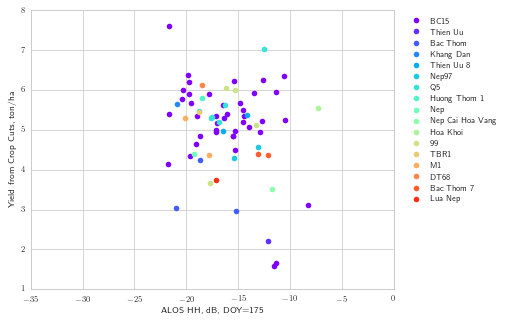

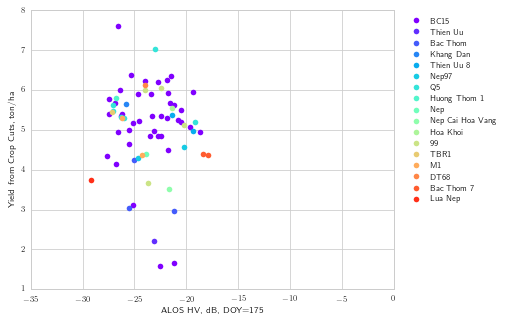

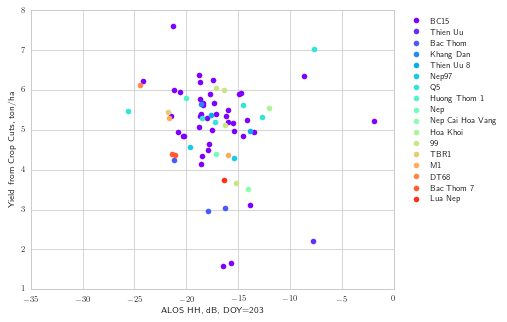

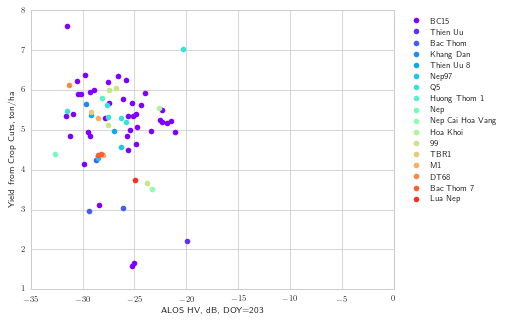

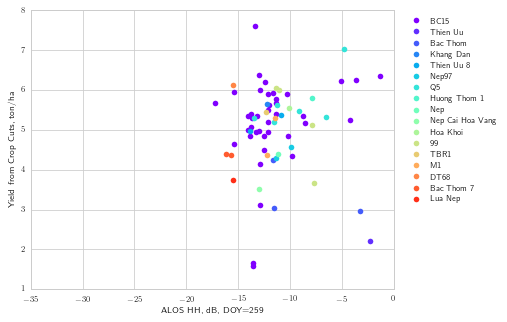

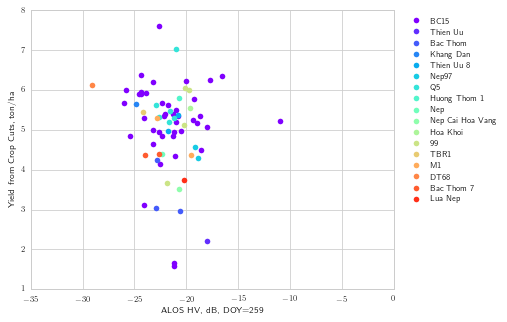

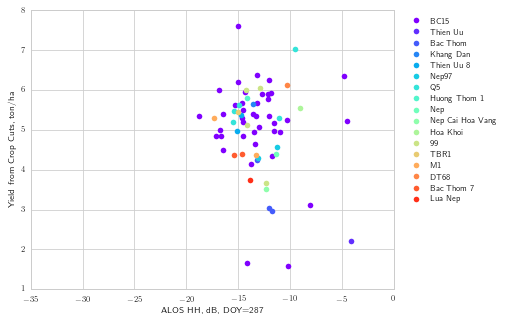

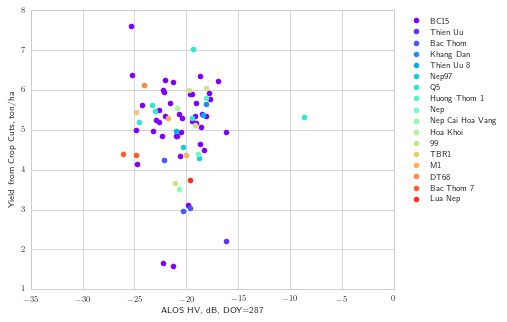

In [53]:
# del ts_data
# ts_data = ts_alos_hh.copy()

use_plotly = False
figsize = (6.5, 5)

doy_list = ts_alos_hh.columns.values

# valid_flag = single_crop_pix_flag
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

crop_type = crop_yield_field.loc[valid_keys, 'variety'].unique()
n_crop_type = len(crop_type)
print "Number of Crop Type = ", n_crop_type
cmap = plt.get_cmap("rainbow")
crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)  

xlim = (-35, 0)
for doy in doy_list:
    fig, ax = plt.subplots(figsize=figsize)
    for ct in crop_type:
        tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
        ax.plot(ts_alos_hh.loc[tmp_keys, doy], crop_yield_field.loc[tmp_keys, 'yield_field'], 
                'o', color=crop_type_color.loc[ct], 
                label='{0:s}'.format(str(ct)))
    plt.setp(ax, xlabel='ALOS HH, dB, DOY={0:d}'.format(doy), ylabel='Yield from Crop Cuts, ton/ha', 
             xlim=xlim)
    if use_plotly:
        plotly_fig = plotly.tools.mpl_to_plotly(fig)
        iplot(plotly_fig)
    else:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
        plt.savefig('../figures/crop_yield_vs_alos_hh_doy_{0:03d}.png'.format(doy), 
                    dpi=300, bbox_inches='tight', pad_inches=0.)

    fig, ax = plt.subplots(figsize=figsize)
    for ct in crop_type:
        tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
        ax.plot(ts_alos_hv.loc[tmp_keys, doy], crop_yield_field.loc[tmp_keys, 'yield_field'], 
                'o', color=crop_type_color.loc[ct], 
                label='{0:s}'.format(str(ct)))
    plt.setp(ax, xlabel='ALOS HV, dB, DOY={0:d}'.format(doy), ylabel='Yield from Crop Cuts, ton/ha', 
             xlim=xlim)
    if use_plotly:
        plotly_fig = plotly.tools.mpl_to_plotly(fig)
        iplot(plotly_fig)
    else:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
        plt.savefig('../figures/crop_yield_vs_alos_hv_doy_{0:03d}.png'.format(doy), 
                    dpi=300, bbox_inches='tight', pad_inches=0.)

In [54]:
# ALOS diff. or ratio v.s. crop yield

use_plotly = True
doy1 = 259
doy2 = 287

cond_list = (single_crop_pix_flag.loc[ts_data.index],
             np.ones(len(ts_data.index), dtype=np.bool))
valid_flag = reduce(np.logical_and, cond_list)
valid_ind = np.where(valid_flag)[0]
single_crop_keys = ts_alos_hh.index.values[valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_crop_keys)

alos_keys = single_crop_keys

crop_type = crop_yield_field.loc[alos_keys, 'variety'].unique()
n_crop_type = len(crop_type)
print "Number of Crop Type = ", n_crop_type
cmap = plt.get_cmap("rainbow")
crop_type_color = pd.Series([cmap(v) for v in np.arange(0, 1, 1./n_crop_type)], index=crop_type)  

fig, ax = plt.subplots(figsize=(6.5, 5))
for ct in crop_type:
    tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
    ax.plot(ts_alos_hh.loc[tmp_keys, doy1]-ts_alos_hv.loc[tmp_keys, doy1], crop_yield_field.loc[tmp_keys, 'yield_field'], 
            'o', color=crop_type_color.loc[ct], 
            label='{0:s}'.format(str(ct)))
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='Yield from Crop Cuts, ton/ha')
if use_plotly:
    plotly_fig = plotly.tools.mpl_to_plotly(fig)
    iplot(plotly_fig)
else:
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.savefig('../figures/crop_yield_vs_alos_hh_doy_{0:03d}.png'.format(doy), 
                dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots(figsize=(6.5, 5))
for ct in crop_type:
    tmp_keys = [k for k in valid_keys if crop_yield_field.loc[k, "variety"]==ct]
    ax.plot(ts_alos_hh.loc[tmp_keys, doy2]-ts_alos_hv.loc[tmp_keys, doy2], crop_yield_field.loc[tmp_keys, 'yield_field'], 
            'o', color=crop_type_color.loc[ct], 
            label='{0:s}'.format(str(ct)))
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='Yield from Crop Cuts, ton/ha')
if use_plotly:
    plotly_fig = plotly.tools.mpl_to_plotly(fig)
    iplot(plotly_fig)
else:
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

220
220
Number of Crop Type =  27


220
220
['015625-p18' '045840-p11' '068333-p11']


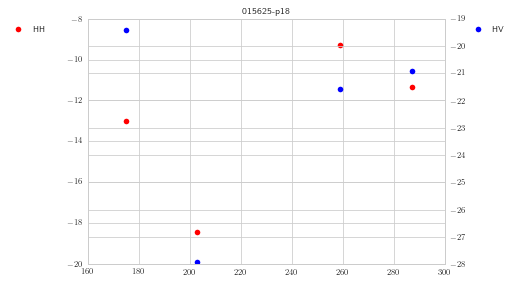

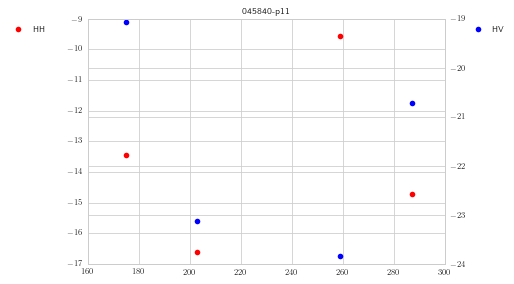

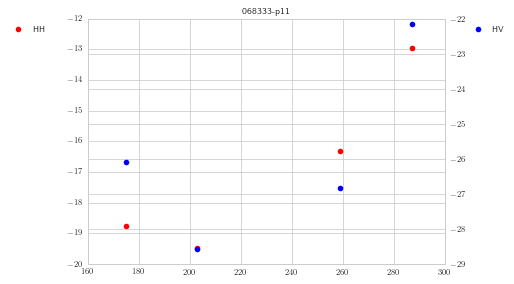

In [55]:
cond_list = (single_crop_pix_flag.loc[ts_data.index],
             np.ones(len(ts_data.index), dtype=np.bool))
valid_flag = reduce(np.logical_and, cond_list)
valid_ind = np.where(valid_flag)[0]
single_crop_keys = ts_alos_hh.index.values[valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_crop_keys)

select_keys = np.random.choice(single_crop_keys, size=3, replace=False)
print select_keys
for k in select_keys:
    fig, ax = plt.subplots()
    ts_doy = ts_alos_hh.columns.values
    ax.plot(ts_doy, ts_alos_hh.loc[k, :], 'or', label="HH")
    twin_ax = ax.twinx()
    twin_ax.plot(ts_doy, ts_alos_hv.loc[k, :], 'ob', label="HV")    
    plt.setp(ax, title=k)
    ax.legend(loc="upper right", bbox_to_anchor=(-0.1, 1))
    twin_ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

### ALOS HH

In [56]:
# del ts_data
# ts_data = ts_alos_hh.copy()

# # ALOS v.s. Crop yield

# doy = 259

# valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, crop_pix_flag))
# valid_ind = np.where(valid_flag)[0]
# valid_keys = ts_data.index.values[valid_ind]
# print np.sum(crop_pix_flag)
# print len(valid_keys)

# single_valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, single_crop_pix_flag))
# single_valid_ind = np.where(single_valid_flag)[0]
# single_valid_keys = ts_data.index.values[single_valid_ind]
# print np.sum(single_crop_pix_flag)
# print len(single_valid_keys)

# fig, ax = plt.subplots()
# ax.plot(ts_alos_hh.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
# ax.plot(ts_alos_hh.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
# plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='Crop yield')
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# fig, ax = plt.subplots()
# ax.plot(ts_alos_hv.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
# ax.plot(ts_alos_hv.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
# plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='Crop yield')
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# fig, ax = plt.subplots()
# ax.plot(ts_alos_hh.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
# ax.plot(ts_alos_hh.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
# plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# fig, ax = plt.subplots()
# ax.plot(ts_alos_hv.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
# ax.plot(ts_alos_hv.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
# plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)